This notebook loads the pickled dictionary with the presidents' raw and aggregated popularity, concatenates the raw popularity of each one, and saves all these data in a unique CSV file for sharing

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr

from scipy.special import expit as logistic

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

In [3]:
PARTIES = {
    "chirac2": "right",
    "sarkozy": "right",
    "hollande": "left",
    "macron": "center",
}

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
all_presidents = pd.read_excel(
    "../data/raw_popularity_presidents.xlsx", index_col=0, parse_dates=True
)
all_presidents

president sondage  samplesize        method  approve_pr  \
1978-09-28       vge  Kantar        1040  face to face        60.0   
1978-10-17       vge    Ifop         949         phone        52.0   
1978-10-28       vge  Kantar         964  face to face        59.0   
1978-11-19       vge    Ifop        1069         phone        53.0   
1978-11-24       vge  Kantar         928  face to face        62.0   
...              ...     ...         ...           ...         ...   
2020-07-10    macron    Ifop        1018      internet        38.0   
2020-07-16    macron     BVA        1000      internet        39.0   
2020-07-16    macron    Ifop         974      internet        37.0   
2020-07-22    macron  Harris         960      internet        50.0   
2020-08-05    macron   Elabe        1002      internet        39.0   

            disapprove_pr  
1978-09-28           33.0  
1978-10-17           35.0  
1978-10-28           34.0  
1978-11-19           37.0  
1978-11-24           33.0  
...                   ...  
2020-07-10           62.0  
2020-07-16           61.0  
2020-07-16           63.0  
2020-07-22           50.0  
2020-08-05           56.0  

[1875 rows x 6 columns]

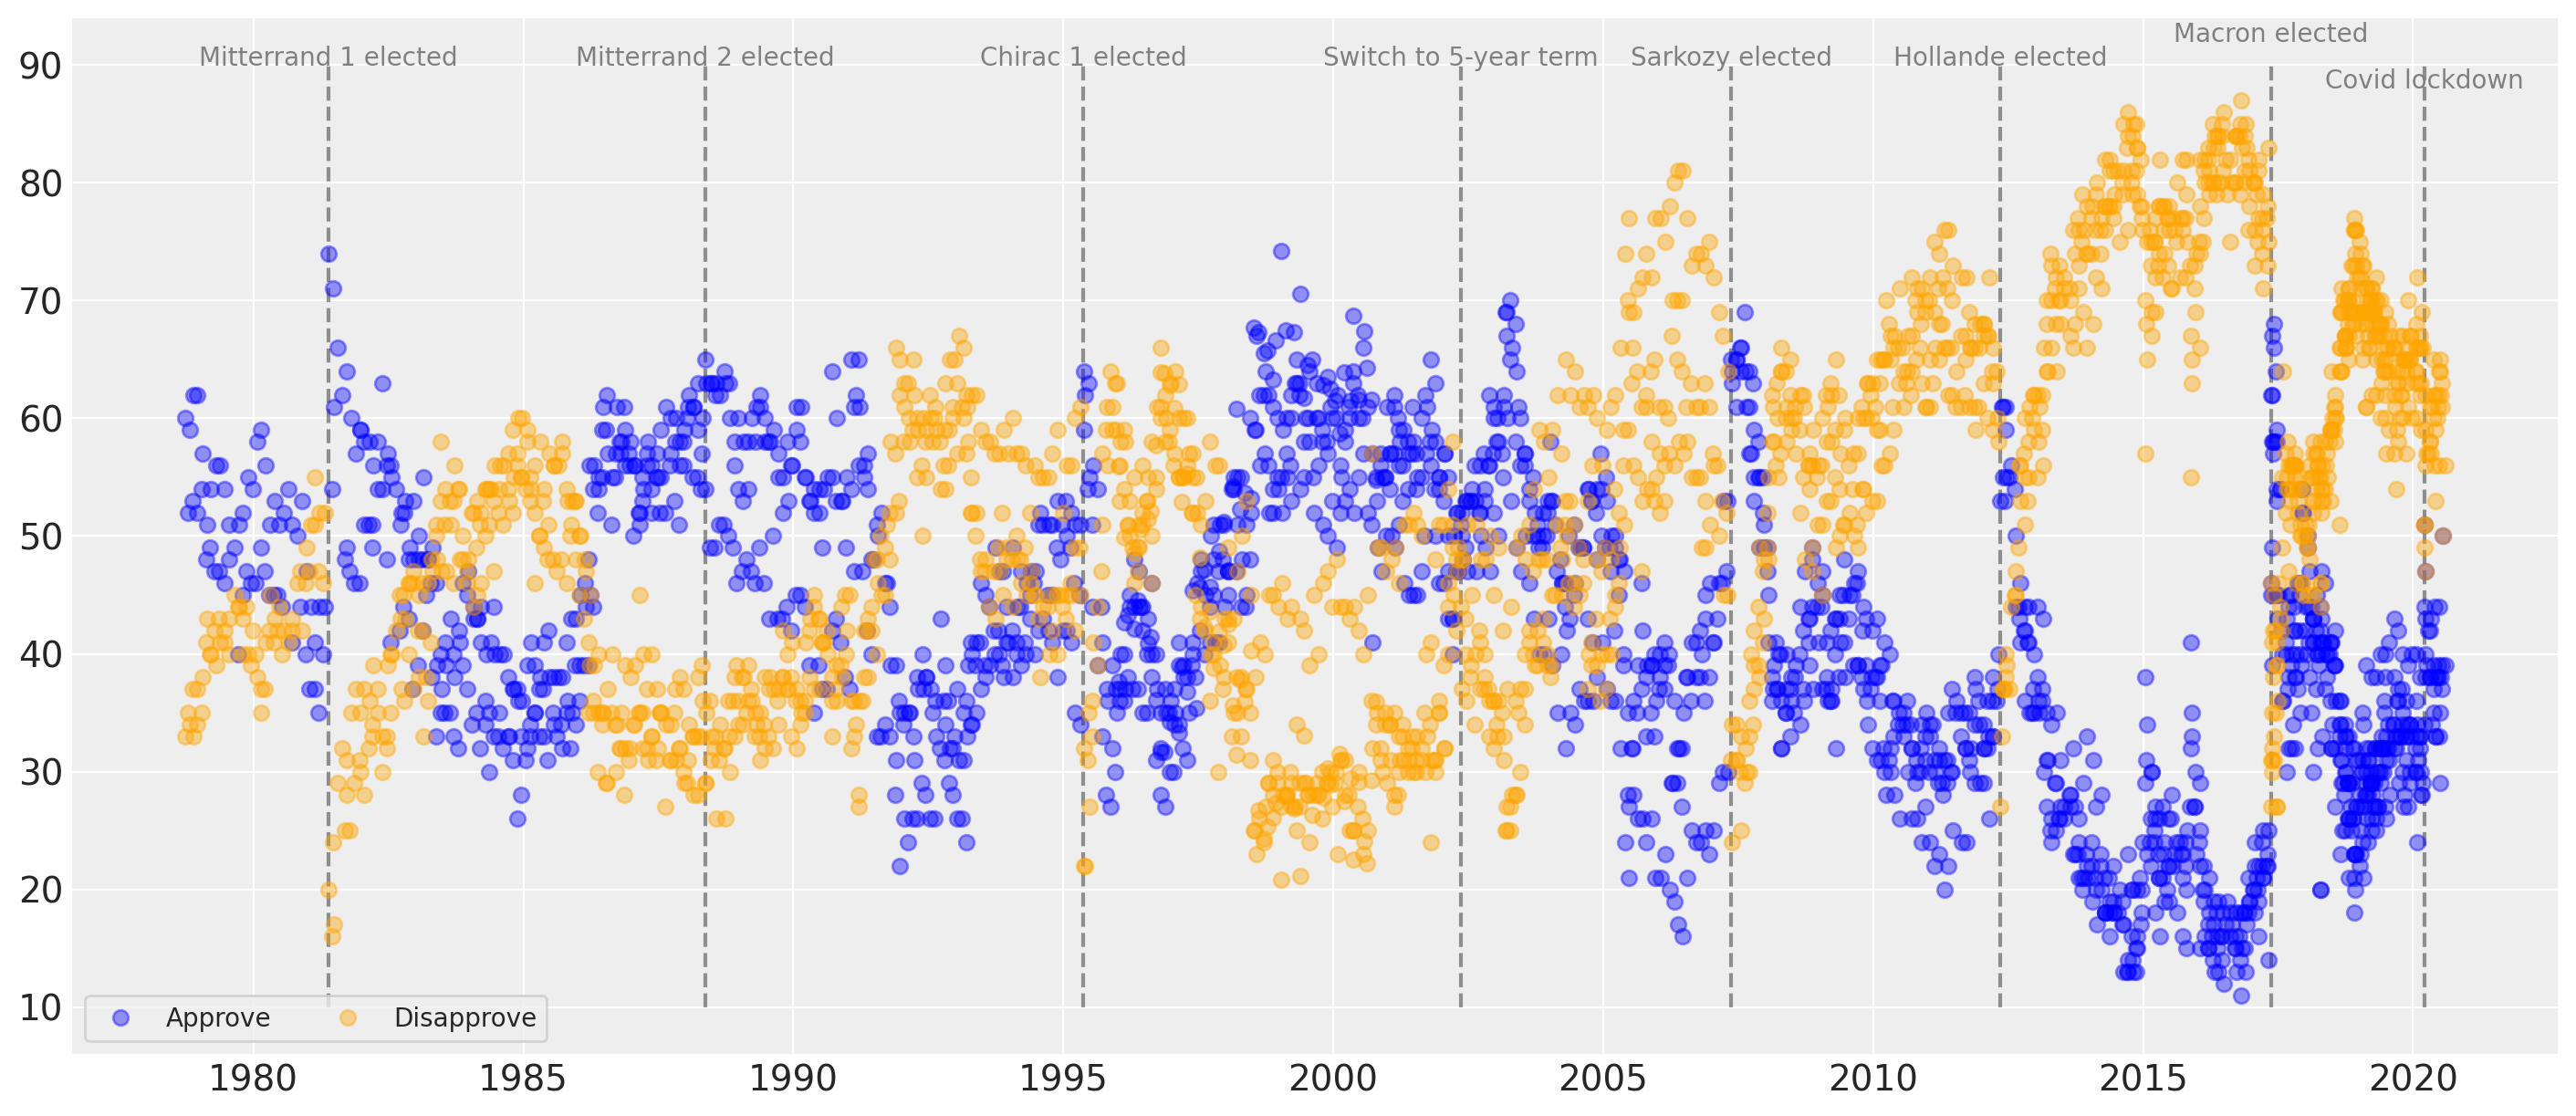

In [6]:
_, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.plot(
    all_presidents.index, all_presidents.approve_pr, "ob", label="Approve", alpha=0.4
)
ax.plot(
    all_presidents.index,
    all_presidents.disapprove_pr,
    "o",
    color="orange",
    label="Disapprove",
    alpha=0.4,
)

ax.vlines(pd.to_datetime("1981-05-25"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("1981-05-25"),
    90,
    "Mitterrand 1 elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("1988-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("1988-05-16"),
    90,
    "Mitterrand 2 elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("1995-05-18"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("1995-05-18"),
    90,
    "Chirac 1 elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2002-05-14"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2002-05-14"),
    90,
    "Switch to 5-year term",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2007-05-16"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2007-05-16"),
    90,
    "Sarkozy elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2012-05-11"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2012-05-11"),
    90,
    "Hollande elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2017-05-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2017-05-17"),
    92,
    "Macron elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2020-03-17"), 10, 90, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2020-03-17"),
    88,
    "Covid lockdown",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

plt.legend(fontsize=10, ncol=2, loc="lower left", frameon=True);

In [5]:
# restrict data to after the switch to 5-year term
d = all_presidents.loc[all_presidents.index >= pd.to_datetime("2002-05-05")]

# convert to proportions
d[["approve_pr", "disapprove_pr"]] = d[["approve_pr", "disapprove_pr"]].copy() / 100
d = d.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

# raw monthly average to get fixed time intervals
d = d.groupby("president").resample("M").mean().reset_index(level=0).sort_index()

d["party"] = d.president.replace(PARTIES)

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [6]:
ELECTION_FLAGS = (
    (d.index.year == 2002) & (d.index.month == 5)
    | (d.index.year == 2007) & (d.index.month == 5)
    | (d.index.year == 2012) & (d.index.month == 5)
    | (d.index.year == 2017) & (d.index.month == 5)
)
d["election_flag"] = 0
d.loc[ELECTION_FLAGS, "election_flag"] = 1

# convert to nbr of successes
d["N_approve"] = d.samplesize * d["p_approve"]
d["N_disapprove"] = d.samplesize * d["p_disapprove"]
d[["N_approve", "N_disapprove"]] = d[["N_approve", "N_disapprove"]].round().astype(int)

# compute total trials
d["N_total"] = d.N_approve + d.N_disapprove
d

president   samplesize  p_approve  p_disapprove   party  \
2002-05-31   chirac2   964.250000   0.502500      0.442500   right   
2002-06-30   chirac2   970.000000   0.505000      0.425000   right   
2002-07-31   chirac2   947.333333   0.533333      0.406667   right   
2002-08-31   chirac2  1028.000000   0.520000      0.416667   right   
2002-09-30   chirac2  1017.500000   0.525000      0.420000   right   
...              ...          ...        ...           ...     ...   
2020-04-30    macron  1174.400000   0.406000      0.582000  center   
2020-05-31    macron  1126.428571   0.371429      0.594286  center   
2020-06-30    macron  1124.714286   0.362857      0.612857  center   
2020-07-31    macron   991.200000   0.398000      0.602000  center   
2020-08-31    macron  1002.000000   0.390000      0.560000  center   

            election_flag  N_approve  N_disapprove  N_total  
2002-05-31              1        485           427      912  
2002-06-30              0        490           412      902  
2002-07-31              0        505           385      890  
2002-08-31              0        535           428      963  
2002-09-30              0        534           427      961  
...                   ...        ...           ...      ...  
2020-04-30              0        477           684     1161  
2020-05-31              0        418           669     1087  
2020-06-30              0        408           689     1097  
2020-07-31              0        394           597      991  
2020-08-31              0        391           561      952  

[220 rows x 9 columns]

In [7]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date. Useful for posterior predictions."""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "M")

    return np.asarray(t)

In [8]:
time = dates_to_idx(d.index)
time[:10]

array([0.        , 0.98564652, 2.00414793, 3.02264934, 4.00829586,
       5.02679726, 6.01244379, 7.03094519, 8.0494466 , 8.96938335])

Priors are very important to fit GPs properly, so let's spend some time thinking about our priors for a more refined model of the popularity of the president. We start by the priors for the lengthscale and period parameters:
- `ls_trend`: The lengthscale of the long term trend. It has a wide prior with most of the mass between 1 to 3 years.
- `ls_med`: This is the lengthscale for the short to medium long variations. This prior has most of its mass below 2 years.
- `scale_mixture_rate` of the Rational Quadratic kernel: It is equivalent to using a combination of Exponential Quadratic kernels with different length scales. As the scale mixture rate approaches infinity, the kernel becomes exactly equivalent to the Exponential Quadratic Kernel. We center the prior for this parameter around 3, since we’re expecting that there is some more variation than could be explained by an exponentiated quadratic kernel.
- `period` of the semi-periodic component: We don't have a strong prior on this, so we'll center the period at one year, with the possibility for short-term seasonality as well as longer seasonality.
- `ls_period`: The smoothness of the semi-periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is quite far from a sine wave, so we use a Gamma whose mode is at 2, and a relatively large variance.
- `ls_period_decay`: The periodic decay. The smaller this parameter, the faster the periodicity goes away. I suspect the seasonality of popularity goes away quite quickly, so let's put most of the prior mass between 6 months and 2 years.

If you're a bit lost, that's quite normal: parameters for GPs are not easily interpretable so it takes some time to develop intuition about them -- all the more so because the Gamma distribution is very flexible, so it can take _a lot_ of different shapes. Here are good educational ressources to think about priors in the context of GPs:
- PyMC3's CO2 at Mauna Loa [example notebook](https://docs.pymc.io/notebooks/GP-MaunaLoa.html).
- PyMC3's notebook for [mean and covariance functions](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html).
- PyMC4's notebook for [mean and covariance functions](https://github.com/pymc-devs/pymc4/blob/master/notebooks/GP-Kernels.ipynb).
- Michael Betancourt's ["Probabilistic Building Blocks"](https://betanalpha.github.io/assets/case_studies/probability_densities.html#25_the_gamma_family) case-study.

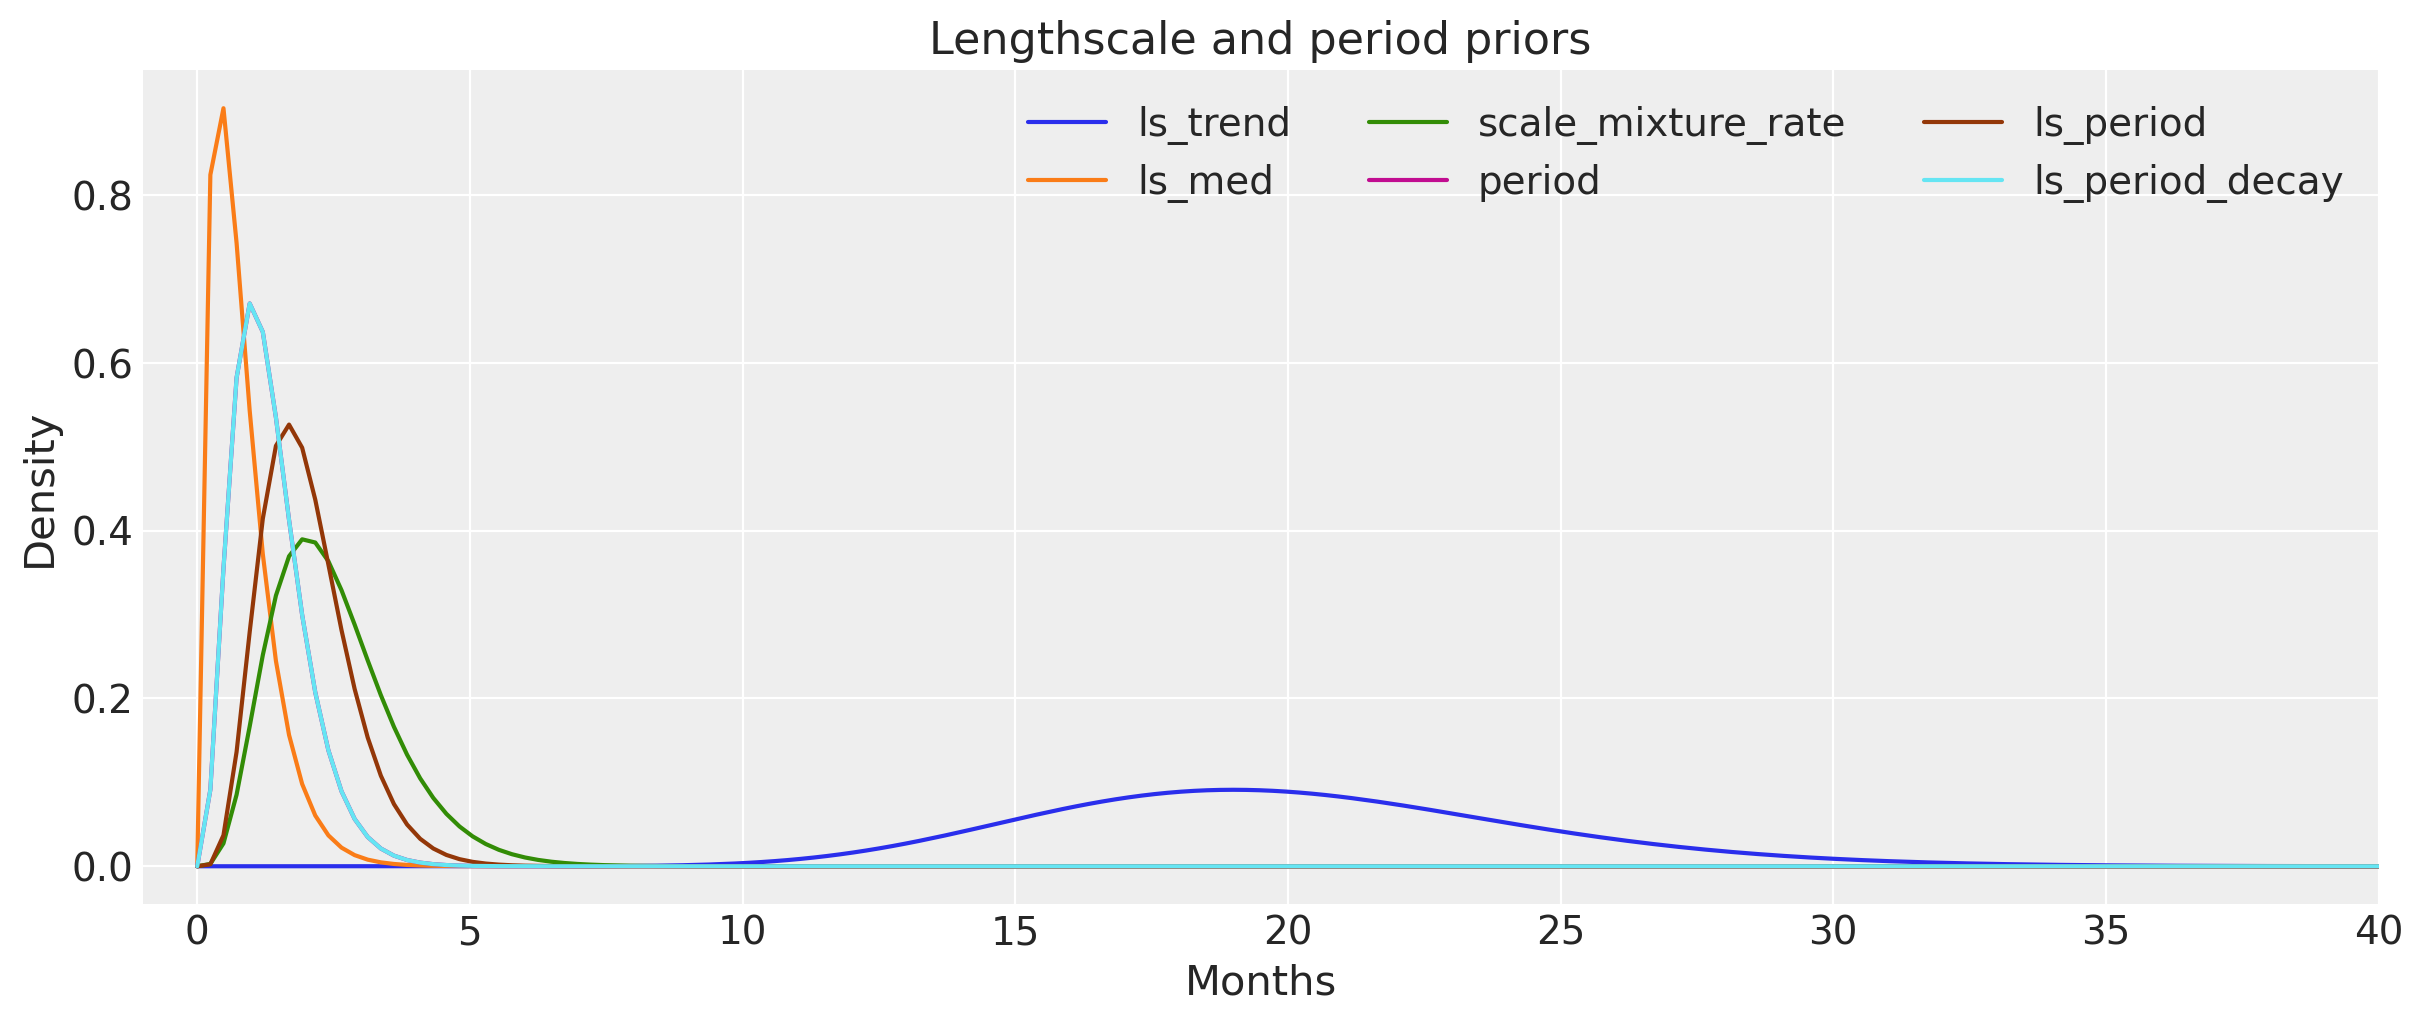

In [11]:
x = np.linspace(0, 120, 500)
priors = [
    ("ls_trend", pm.Gamma.dist(alpha=20, beta=1)),
    ("ls_med", pm.Gamma.dist(alpha=2, beta=2.5)),
    ("scale_mixture_rate", pm.Gamma.dist(alpha=5, beta=2)),
    ("period", pm.Gamma.dist(alpha=4, beta=3)),
    ("ls_period", pm.Gamma.dist(alpha=6, beta=3)),
    ("ls_period_decay", pm.Gamma.dist(alpha=4, beta=3)),
]

fig = plt.figure(figsize=(12, 5))

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlim((-1, 40))
plt.xlabel("Months")
plt.ylabel("Density")
plt.title("Lengthscale and period priors")
plt.legend(ncol=3);

Now we have to think about priors for our scale parameters: `amplitude_trend` (the scale of the long term trend), `amplitude_med` (the scale of the short to medium term component), and `amplitude_per` (the scale of the semi-periodic component). We don't have a lot of prior information about these parameters, so let's choose a weakly informative prior:

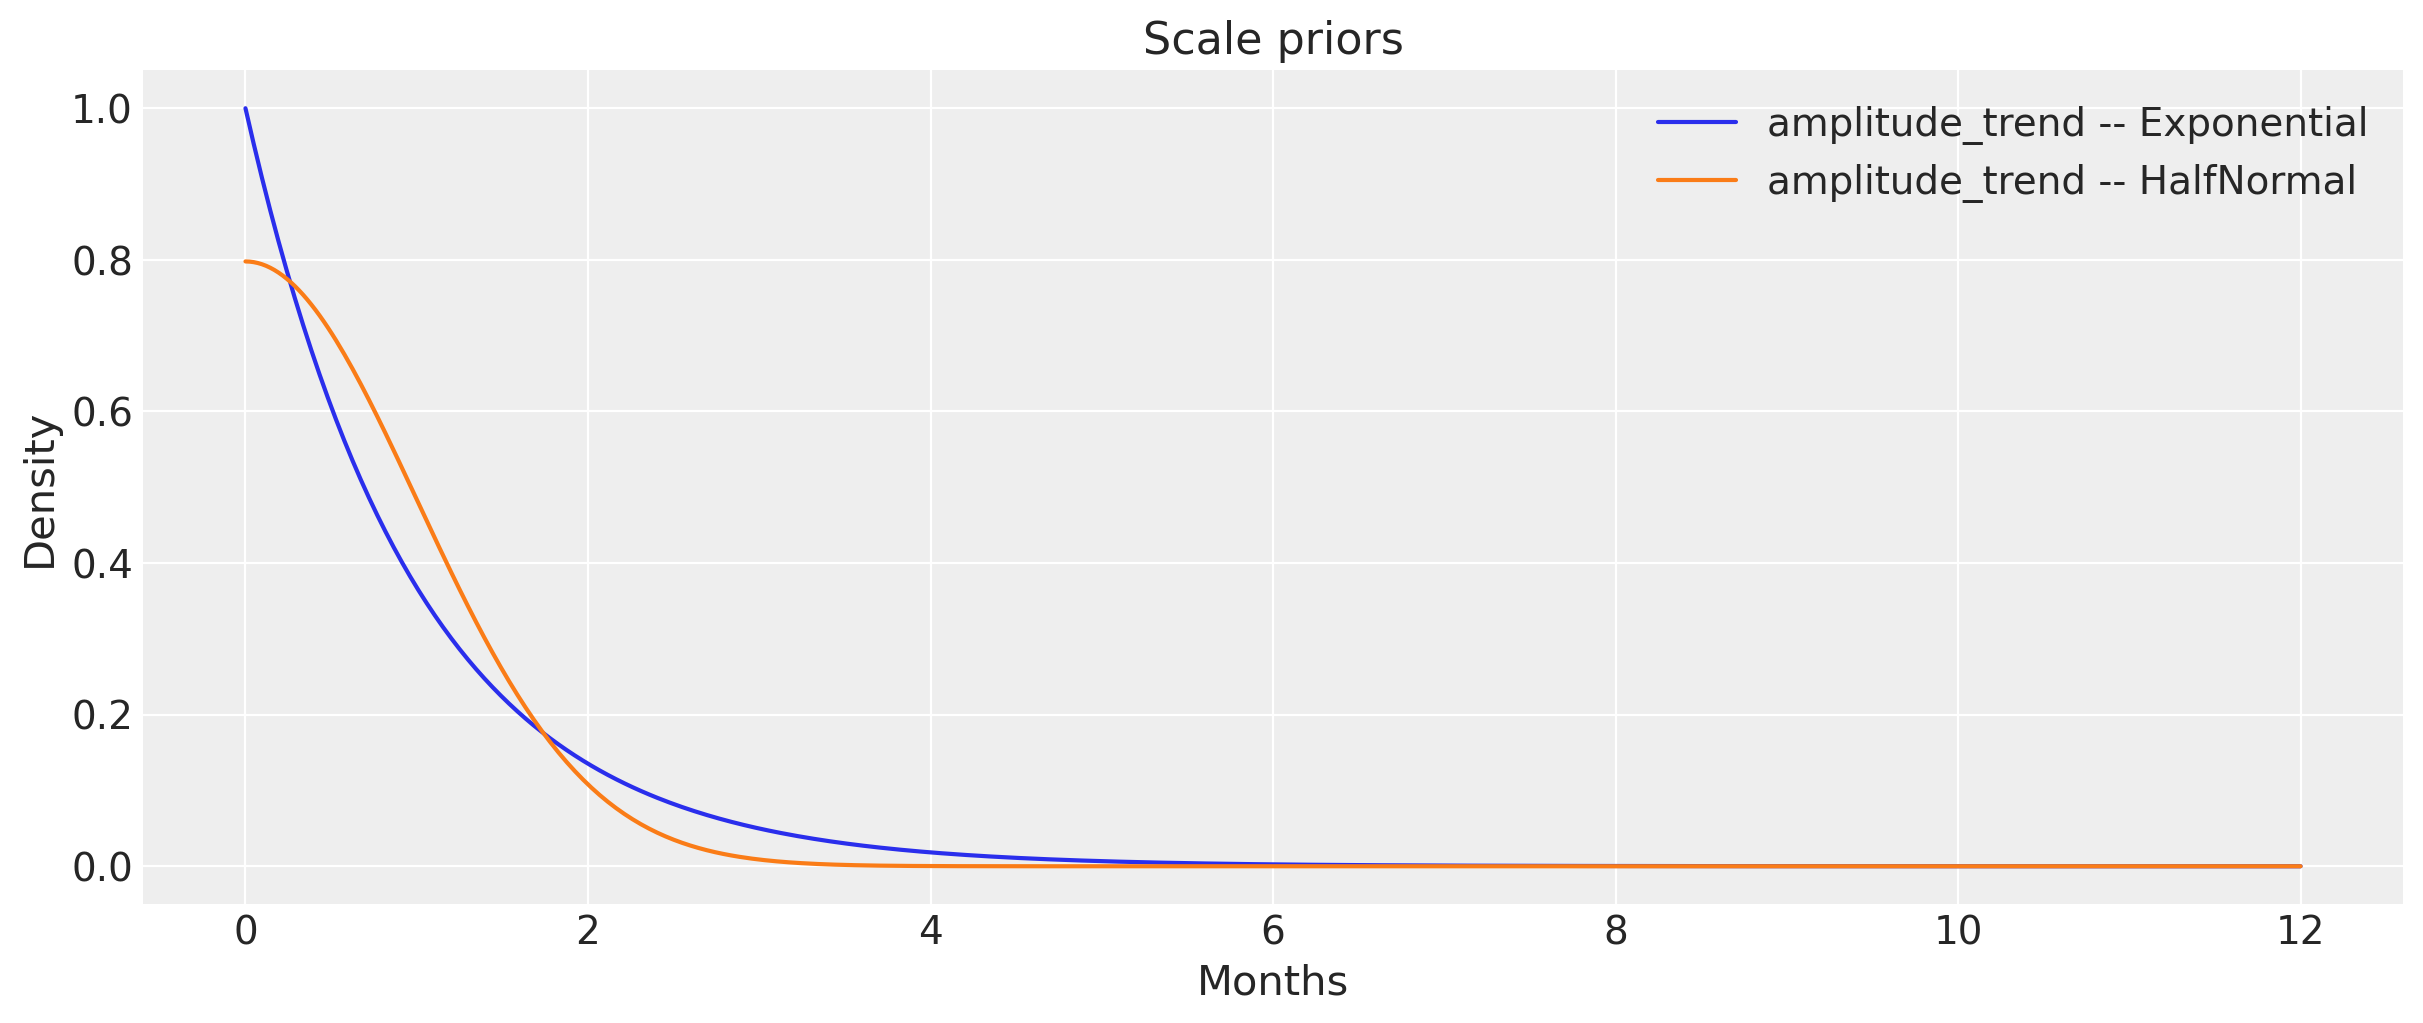

In [9]:
x = np.linspace(0, 12, 500)
priors = [
    ("amplitude_trend -- Exponential", pm.Exponential.dist(1)),
    ("amplitude_trend -- HalfNormal", pm.HalfNormal.dist(1)),
]

fig = plt.figure(figsize=(12, 5))

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlabel("Months")
plt.ylabel("Density")
plt.title("Scale priors")
plt.legend();

And now we can use these priors to simulate samples from the whole GP prior and see if our choices make sense:

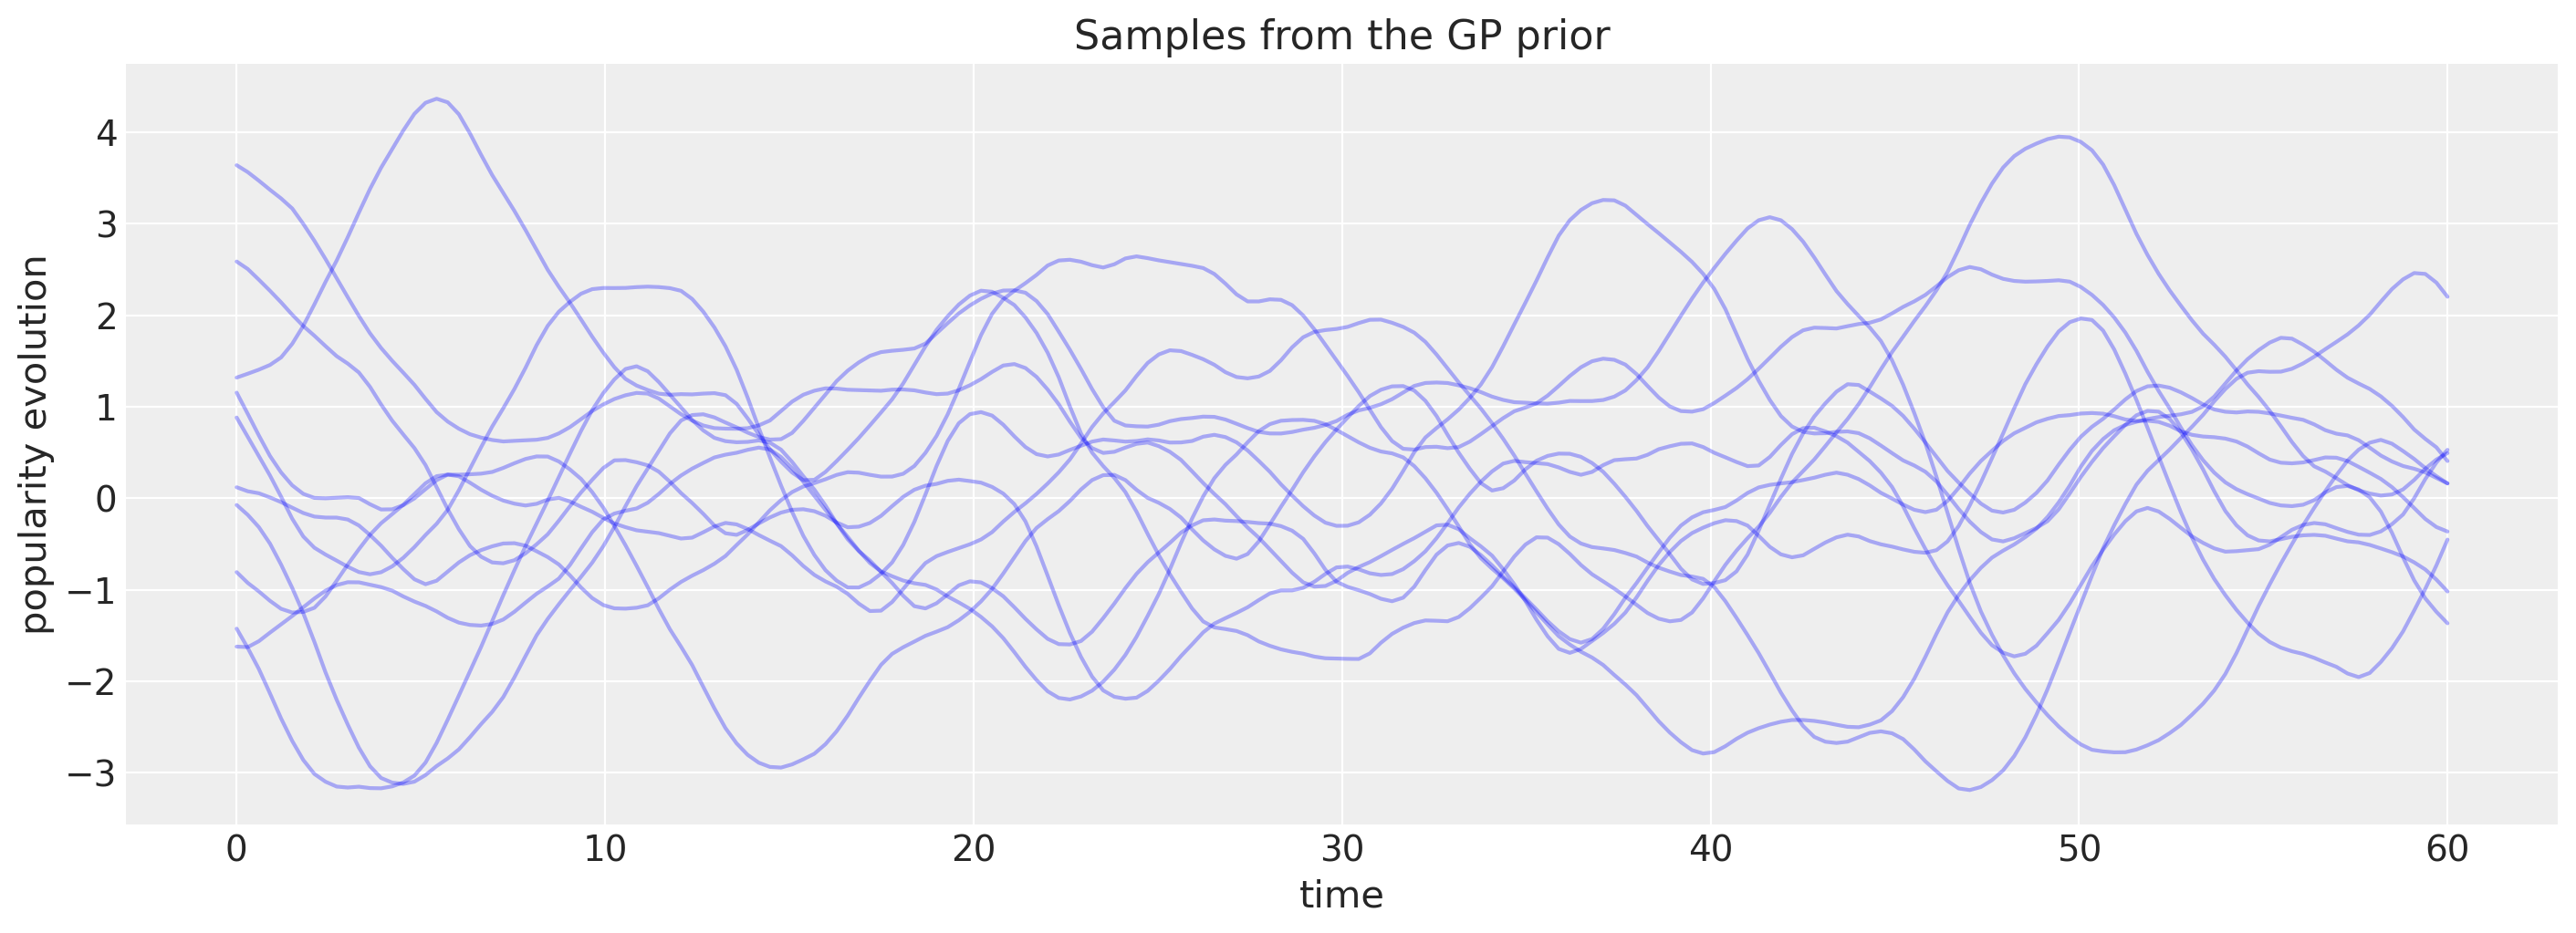

In [17]:
# long term trend
amplitude_trend = pm.HalfNormal.dist(1.0).random(1)
ls_trend = pm.Gamma.dist(alpha=20, beta=1).random(1)
cov_trend = amplitude_trend ** 2 * pm.gp.cov.Matern52(1, ls_trend)

# small/medium term irregularities
amplitude_med = pm.HalfNormal.dist(1.0).random(1)
ls_med = pm.Gamma.dist(alpha=10, beta=2).random(1)
# scale_mixture_rate = pm.Gamma.dist(alpha=5,  beta=2).random(1)
cov_medium = amplitude_med ** 2 * pm.gp.cov.Matern52(1, ls=ls_med)

X = np.linspace(0, 60, 200)[:, None]
cov = cov_trend + cov_medium
K = cov(X).eval()

plt.figure(figsize=(14, 5))
plt.plot(
    X,
    pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=10).T,
    color="b",
    alpha=0.3,
)
plt.title("Samples from the GP prior")
plt.xlabel("time")
plt.ylabel("popularity evolution");

Finally, let's pick a prior for our `baseline` parameter, i.e the intercept of our Gaussian Process regression. In other words, this will be the mean function of our GP -- the value it reverts to when data start lacking. There we have quite a lot of information: 50% popularity is historically quite high for a French president (just take a look at the whole dataset we loaded at the beginning of the NB), so keeping the mean at zero is sub-optimal -- remember that `baseline` lives on the logit scale, so a prior centered at 0 means a prior centered at $logistic(0) = 0.5$ on the outcome space. 

We can do better: based on our domain knowledge, we expect most president to have a baseline popularity between 20% and 50% -- in other words, French people rarely love their presidents but often _really_ dislike them. $Normal(-0.7, 0.5)$ looks reasonable in that regard: it expects 95% of the probability mass to be between -1.7 and 0.3, i.e $logistic(-1.7) = 15\%$ and $logistic(0.3) = 57\%$, with a mean approval of $logistic(-0.7) = 33\%$:

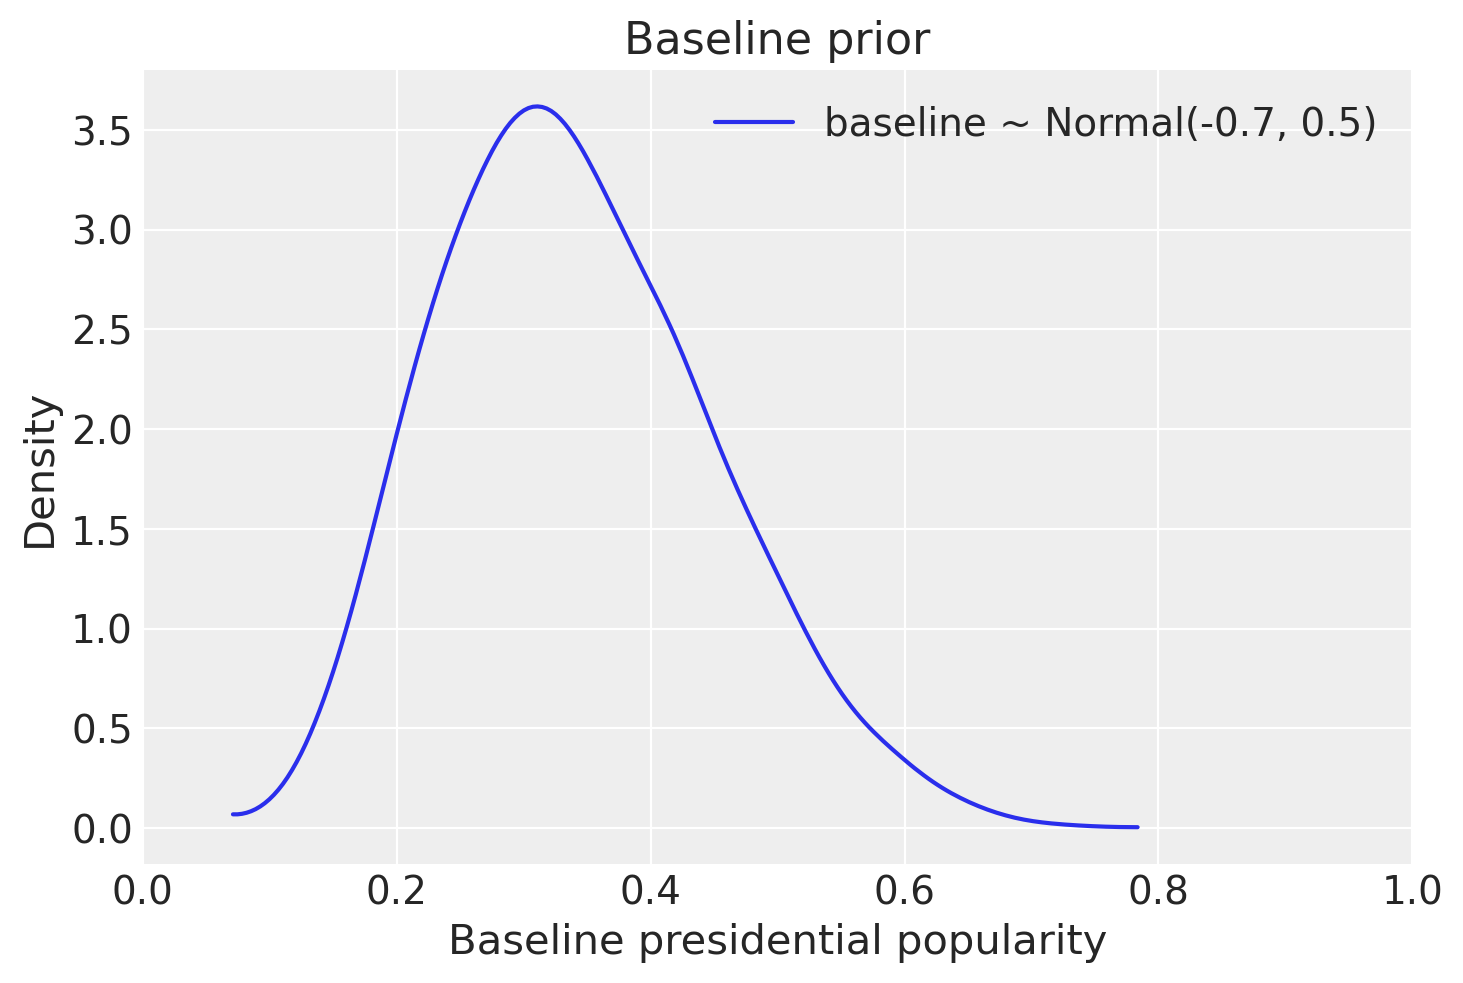

In [22]:
ax = az.plot_kde(
    logistic(pm.Normal.dist(-0.7, 0.5).random(size=20_000)),
    label="baseline ~ Normal(-0.7, 0.5)",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

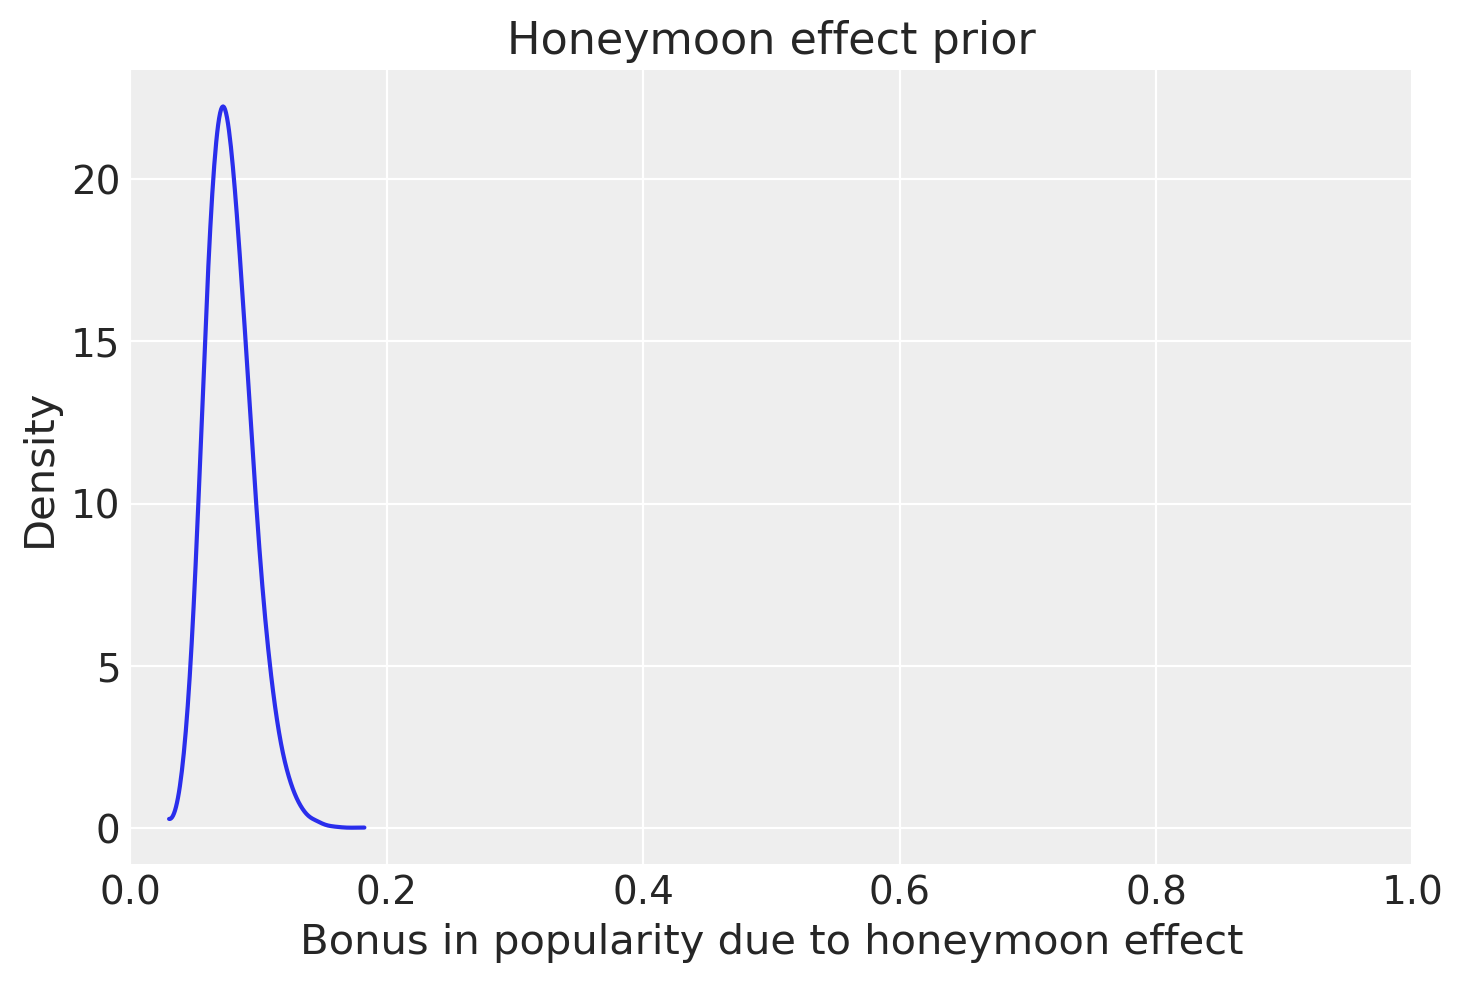

In [23]:
ax = az.plot_kde(logistic(pm.Normal.dist(-2.5, 0.25).random(size=20_000)),)
ax.set_xlim((0, 1))
ax.set_xlabel("Bonus in popularity due to honeymoon effect")
ax.set_ylabel("Density")
ax.set_title("Honeymoon effect prior");

In [9]:
MAX_OBSERVED = len(d.index)
COORDS = {"timesteps": np.arange(MAX_OBSERVED)}

The unemployment data can be found [here](https://www.insee.fr/fr/statistiques/serie/001688526#Telechargement)

In [10]:
unemp = pd.read_csv("../data/predictors/chomage_national_trim.csv", sep=";", skiprows=2).iloc[:, [0, 1]]
unemp.columns = ["date", "unemployment"]
unemp = unemp.sort_values("date")

# as timestamps variables:
unemp.index = pd.period_range(start=unemp.date.iloc[0], periods=len(unemp), freq="Q")
unemp = unemp.drop("date", axis=1)
unemp

unemployment
1975Q1           2.9
1975Q2           3.2
1975Q3           3.5
1975Q4           3.6
1976Q1           3.6
...              ...
2019Q2           8.2
2019Q3           8.2
2019Q4           7.8
2020Q1           7.6
2020Q2           7.0

[182 rows x 1 columns]

In [11]:
d = d.reset_index()

# add quarters to main dataframe:
d.index = pd.DatetimeIndex(d["index"].values).to_period("Q")
d.index.name = "quarter"

# merge with unemployment:
d = d.join(unemp).reset_index().set_index("index")
d.index.name = "month"
d["unemployment"] = d.unemployment.fillna(method="ffill")
d

quarter president   samplesize  p_approve  p_disapprove   party  \
month                                                                        
2002-05-31  2002Q2   chirac2   964.250000   0.502500      0.442500   right   
2002-06-30  2002Q2   chirac2   970.000000   0.505000      0.425000   right   
2002-07-31  2002Q3   chirac2   947.333333   0.533333      0.406667   right   
2002-08-31  2002Q3   chirac2  1028.000000   0.520000      0.416667   right   
2002-09-30  2002Q3   chirac2  1017.500000   0.525000      0.420000   right   
...            ...       ...          ...        ...           ...     ...   
2020-04-30  2020Q2    macron  1174.400000   0.406000      0.582000  center   
2020-05-31  2020Q2    macron  1126.428571   0.371429      0.594286  center   
2020-06-30  2020Q2    macron  1124.714286   0.362857      0.612857  center   
2020-07-31  2020Q3    macron   991.200000   0.398000      0.602000  center   
2020-08-31  2020Q3    macron  1002.000000   0.390000      0.560000  center   

            election_flag  N_approve  N_disapprove  N_total  unemployment  
month                                                                      
2002-05-31              1        485           427      912           7.5  
2002-06-30              0        490           412      902           7.5  
2002-07-31              0        505           385      890           7.5  
2002-08-31              0        535           428      963           7.5  
2002-09-30              0        534           427      961           7.5  
...                   ...        ...           ...      ...           ...  
2020-04-30              0        477           684     1161           7.0  
2020-05-31              0        418           669     1087           7.0  
2020-06-30              0        408           689     1097           7.0  
2020-07-31              0        394           597      991           7.0  
2020-08-31              0        391           561      952           7.0  

[220 rows x 11 columns]

As the most recent values for unemployment are missing, we will impute them automatically while fitting the model. That way, our imputations will be informed by all the information the model has about the other parameters. This is quite simple to do in PyMC3: we just have to declare the unemployment values as a masked array. Also, the model will care about the order of magnitude of the unemployment, not the intrisic values, so we take the log of the unemployment. Finally, we need to standardize the data (mean 0 and standard deviation 1) so that our sampler has a better time sampling. Let's set this up:

In [74]:
# uncertainty in y (polling error + pollsters weights) OR overdispersion
# economy: GRW

with pm.Model(coords=COORDS) as econ_latent_gp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)

    # honeymoon slope
    honeymoon = pm.Normal("honeymoon", -0.5, 0.3)
    
    # log unemployment slope
    log_unemp_effect = pm.Normal("log_unemp_effect", 0., 0.5)

    # long term trend
    amplitude_trend = pm.Exponential("amplitude_trend", 1.0)
    ls_trend = pm.Gamma("ls_trend", alpha=5, beta=2)
    cov_trend = amplitude_trend ** 2 * pm.gp.cov.Matern52(1, ls_trend)

    # instantiate gp
    gp = pm.gp.Latent(cov_func=cov_trend)
    # evaluate GP at time points
    f_time = gp.prior("f_time", X=time[:, None])

    # data
    election_flag = pm.Data("election_flag", d.election_flag.values, dims="timesteps")
    stdz_log_unemployment = pm.Data("stdz_log_unemployment", standardize(np.log(d.unemployment)).values, dims="timesteps")
    # unemployment data is uncertain
    # sd = 0.1 says uncertainty on point expected btw 20% of data std 95% of time
    u_diff = pm.Normal("u_diff", mu=0.0, sigma=0.1, dims="timesteps")
    u_uncert = stdz_log_unemployment + u_diff

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(baseline + f_time + honeymoon * election_flag + log_unemp_effect * u_uncert),
        dims="timesteps",
    )

    y = pm.Binomial("y", p=p, n=d.N_total, observed=d.N_approve, dims="timesteps")

    trace_econ = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=8,
        return_inferencedata=True,
        idata_kwargs={
            "dims": {"f_time": ["timesteps"], "f_time_rotated_": ["timesteps"]}
        },
    )
az.to_netcdf(trace_econ, "trace_raw_econ.nc")
az.plot_trace(trace_econ, compact=True);

In [18]:
az.summary(trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
baseline         -0.56  0.08   -0.71    -0.40       0.00      0.0   2418.31   
honeymoon         0.50  0.06    0.39     0.61       0.00      0.0   4950.05   
log_unemp_effect -0.11  0.06   -0.23     0.01       0.00      0.0   1532.98   
amplitude_trend   0.46  0.05    0.37     0.57       0.00      0.0   1557.93   
ls_trend          3.07  0.26    2.60     3.55       0.01      0.0   1481.37   

                   ess_sd  ess_bulk  ess_tail  r_hat  
baseline          2418.31   2417.17   3554.53    1.0  
honeymoon         4839.46   4972.06   5539.29    1.0  
log_unemp_effect  1532.98   1535.50   3044.21    1.0  
amplitude_trend   1556.87   1588.89   2613.66    1.0  
ls_trend          1481.37   1484.20   2810.49    1.0

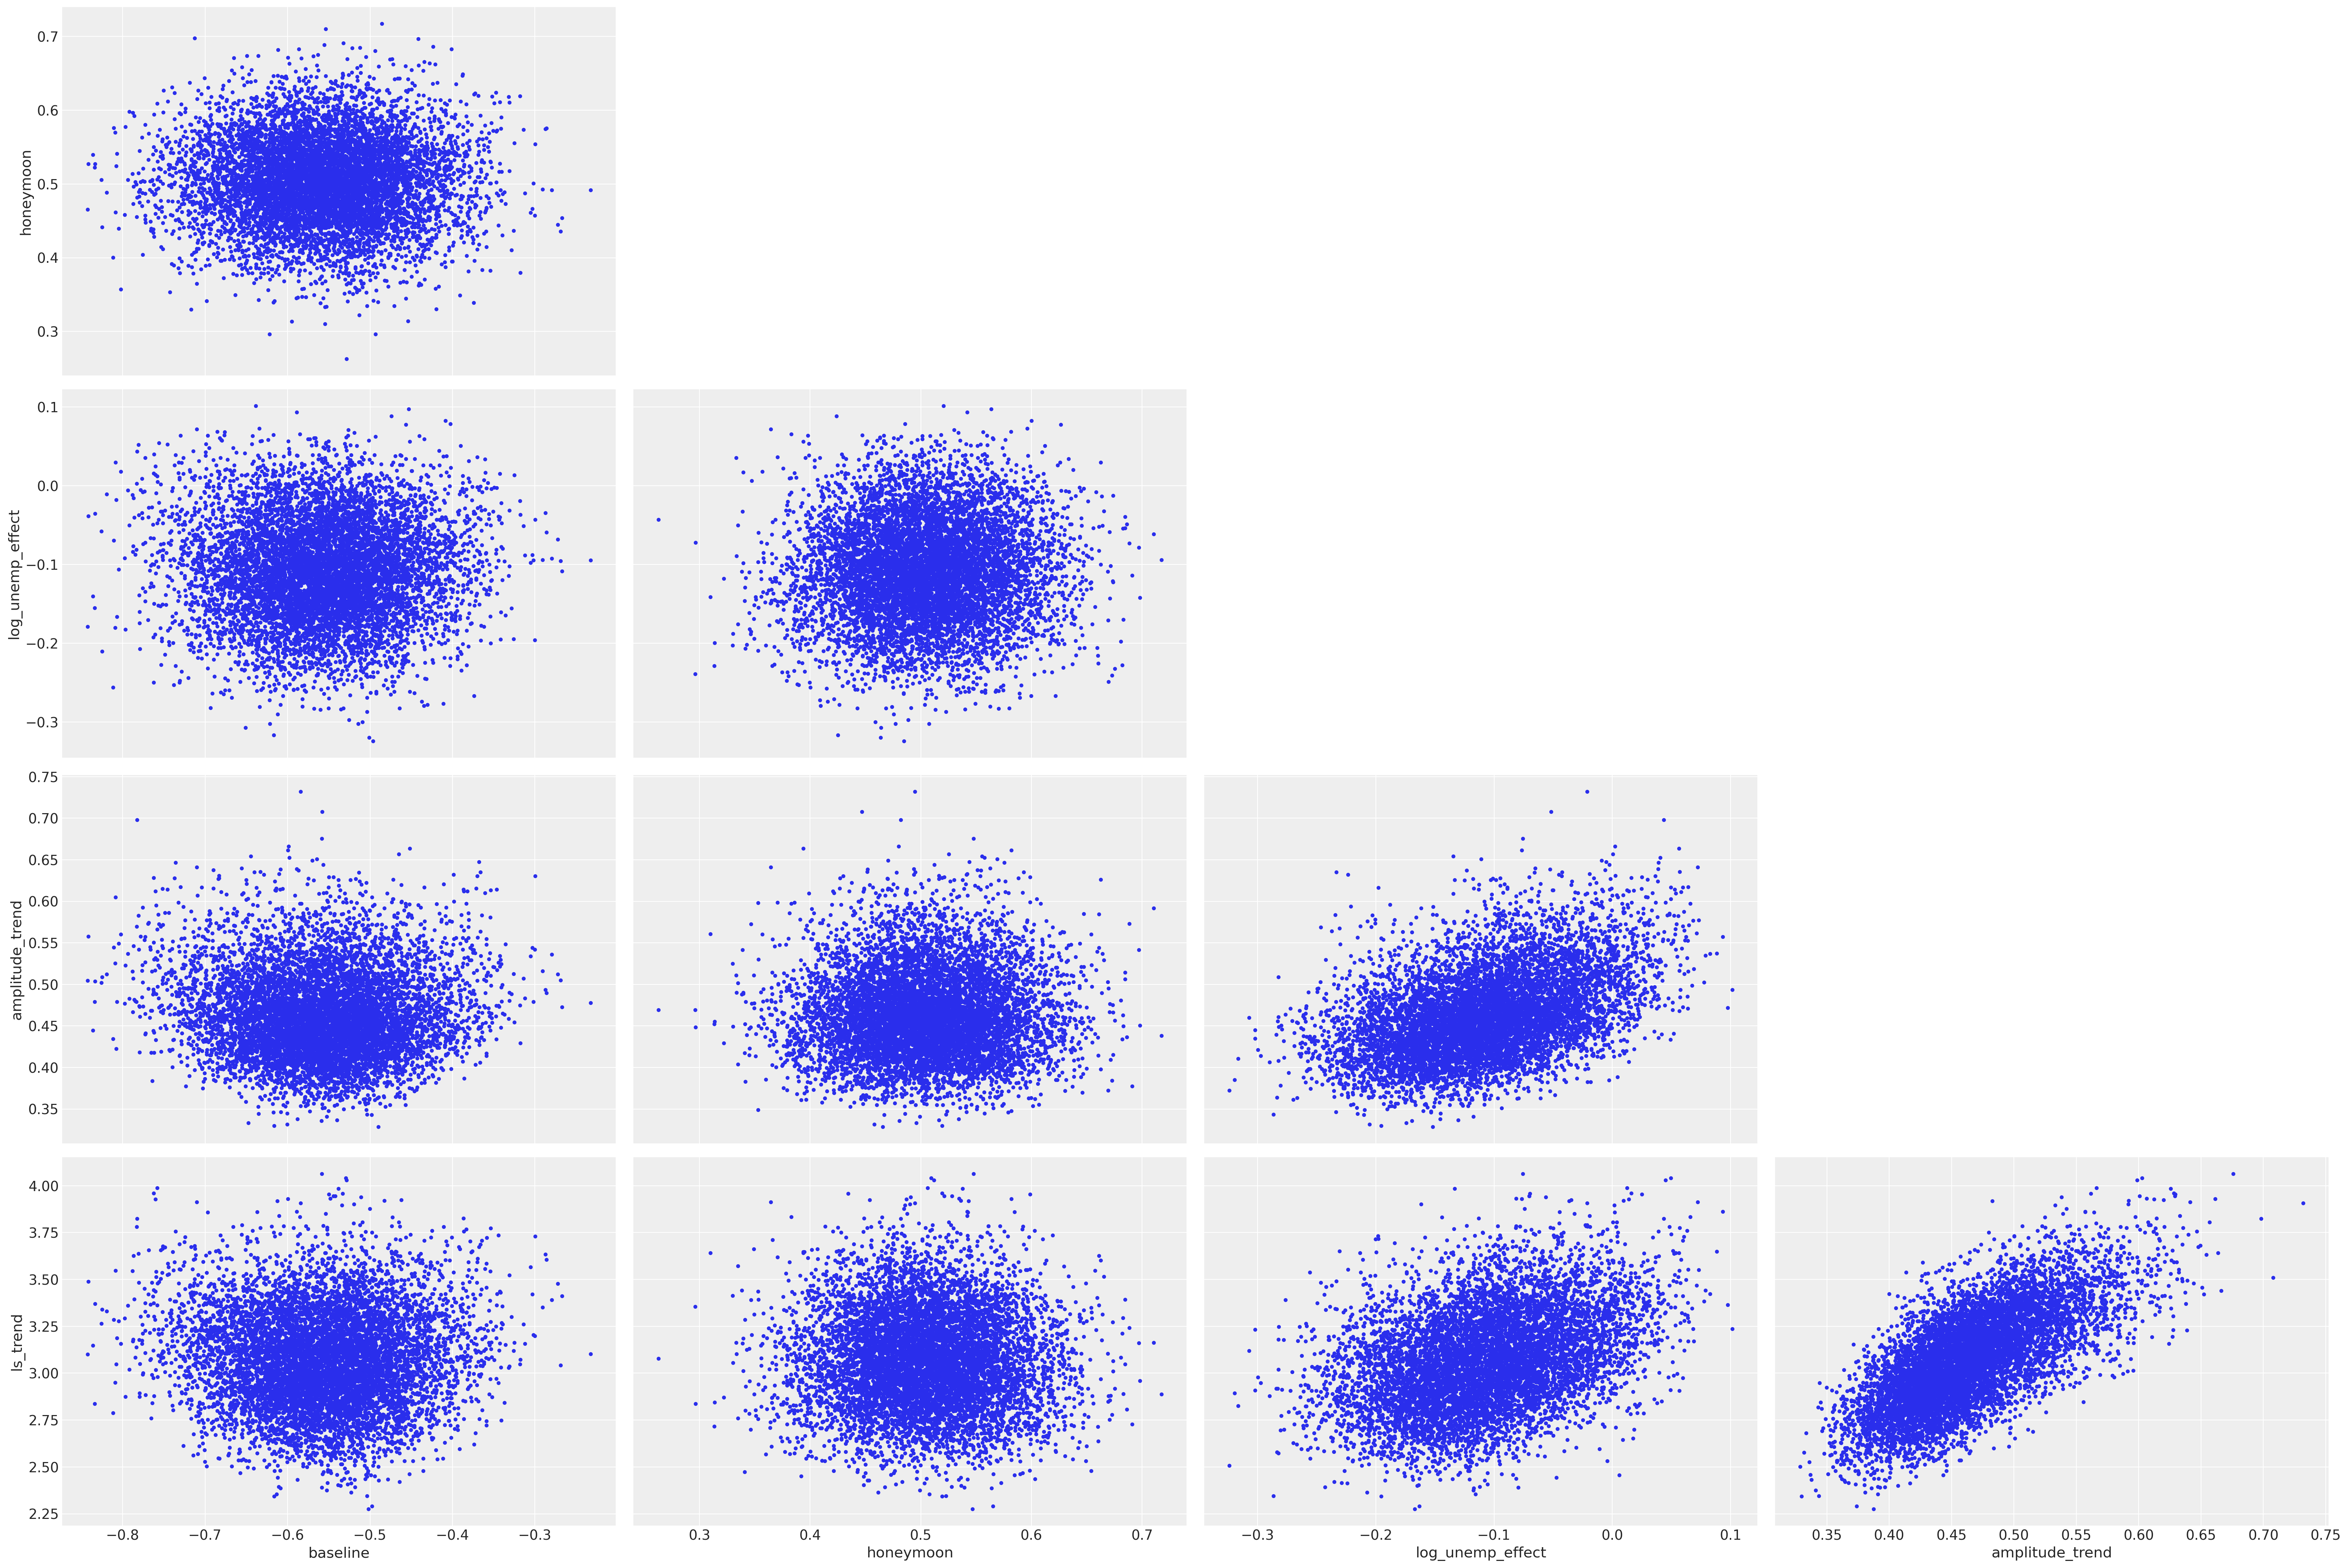

In [19]:
az.plot_pair(trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"], divergences=True);

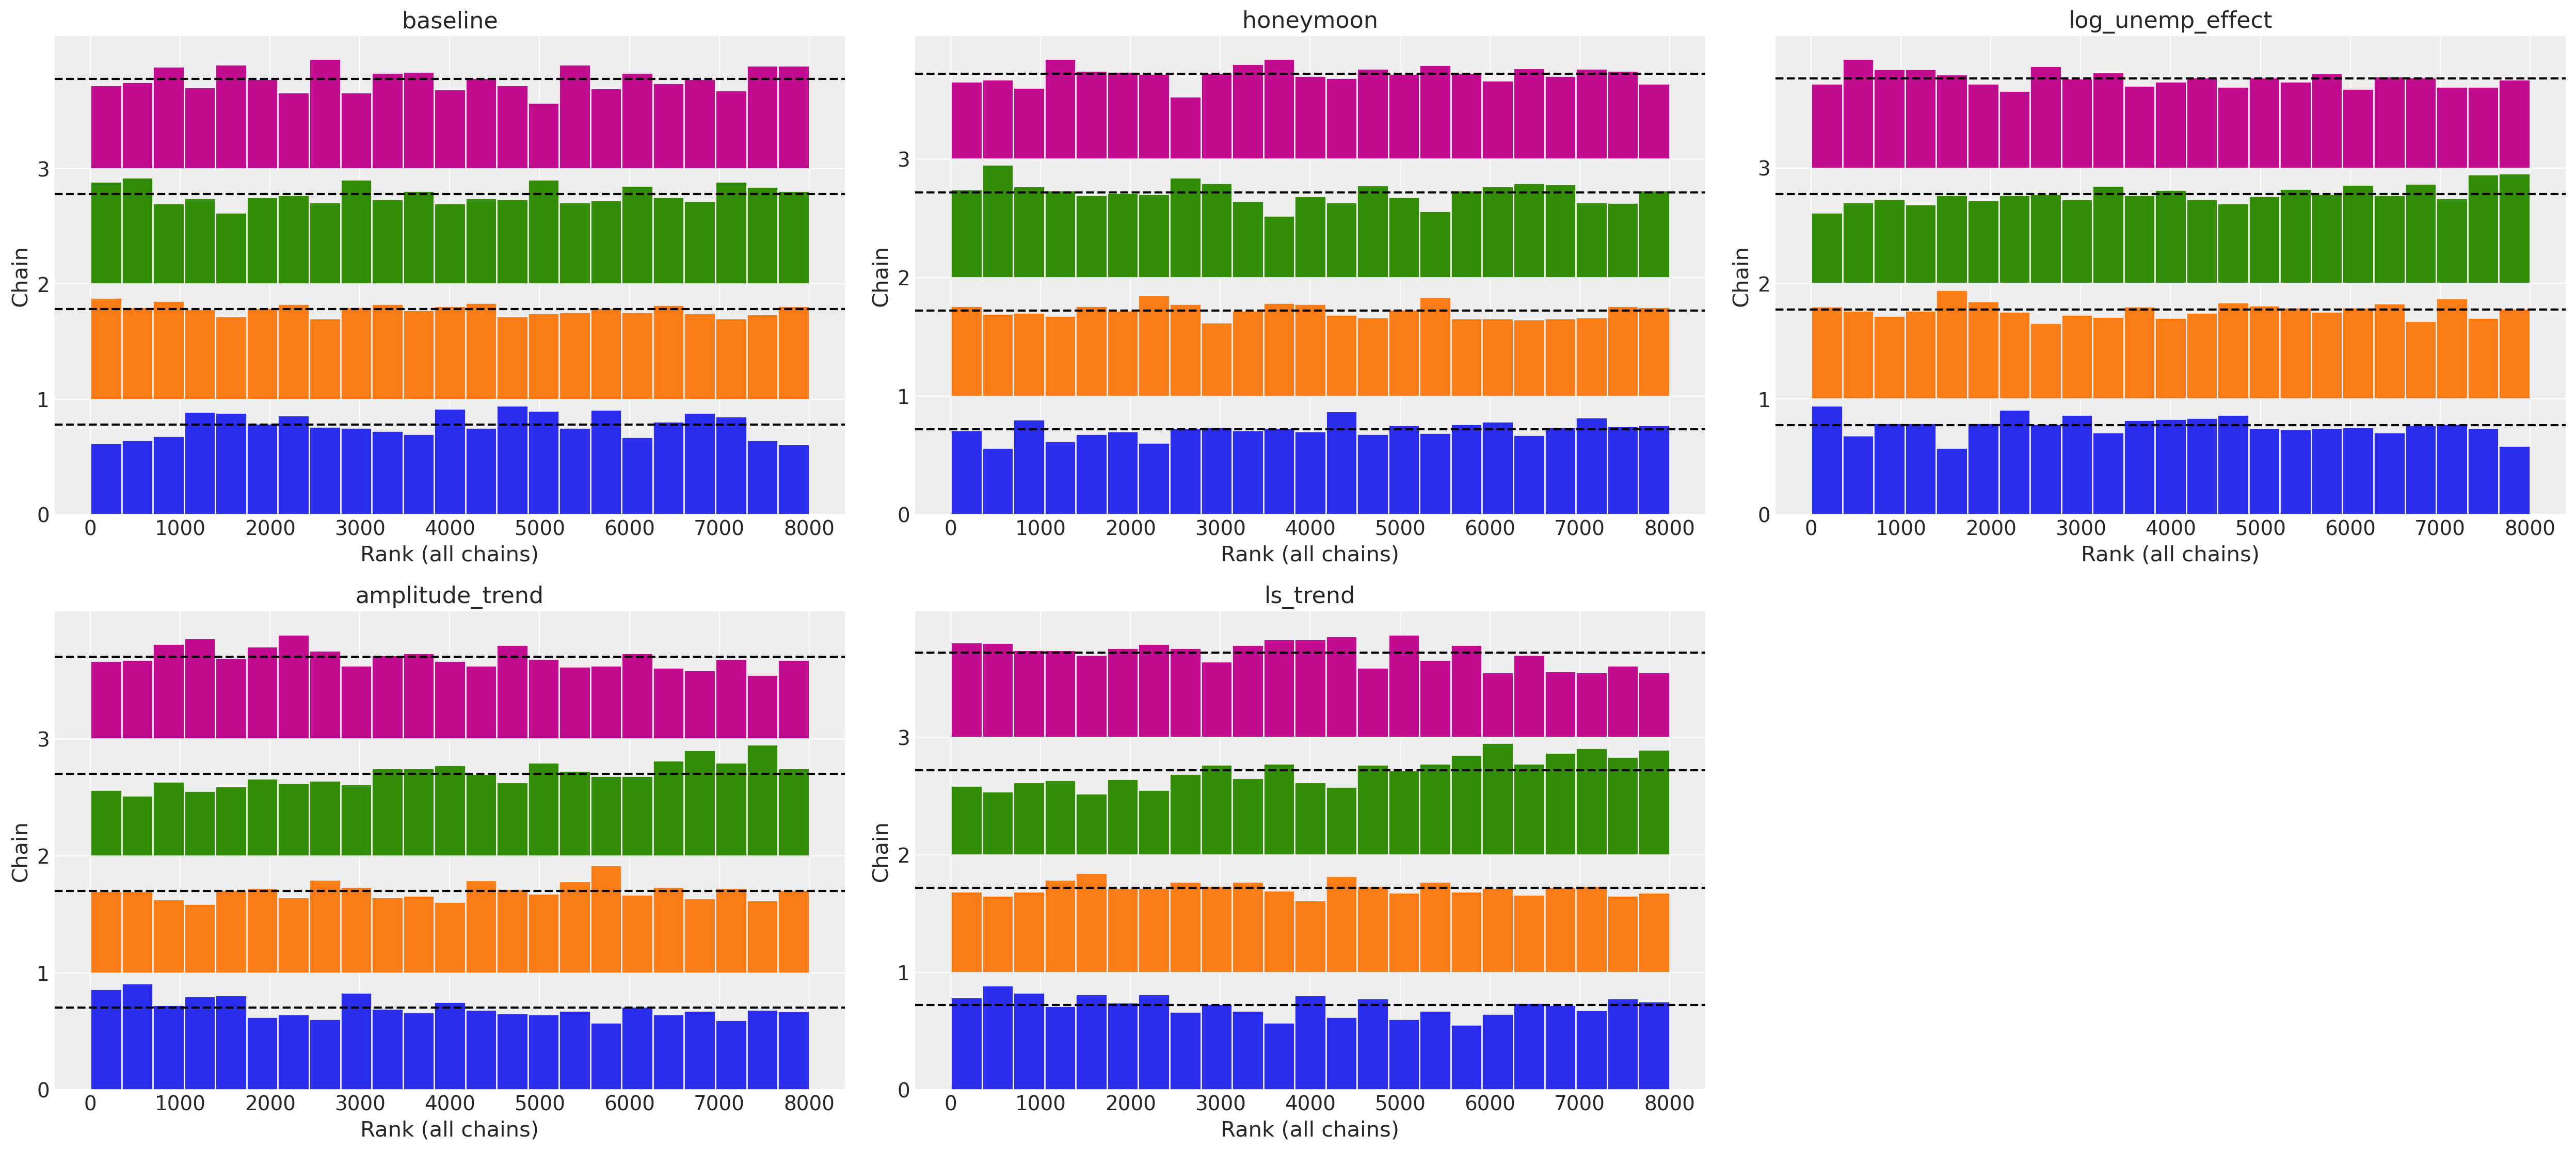

In [20]:
az.plot_rank(trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"]);

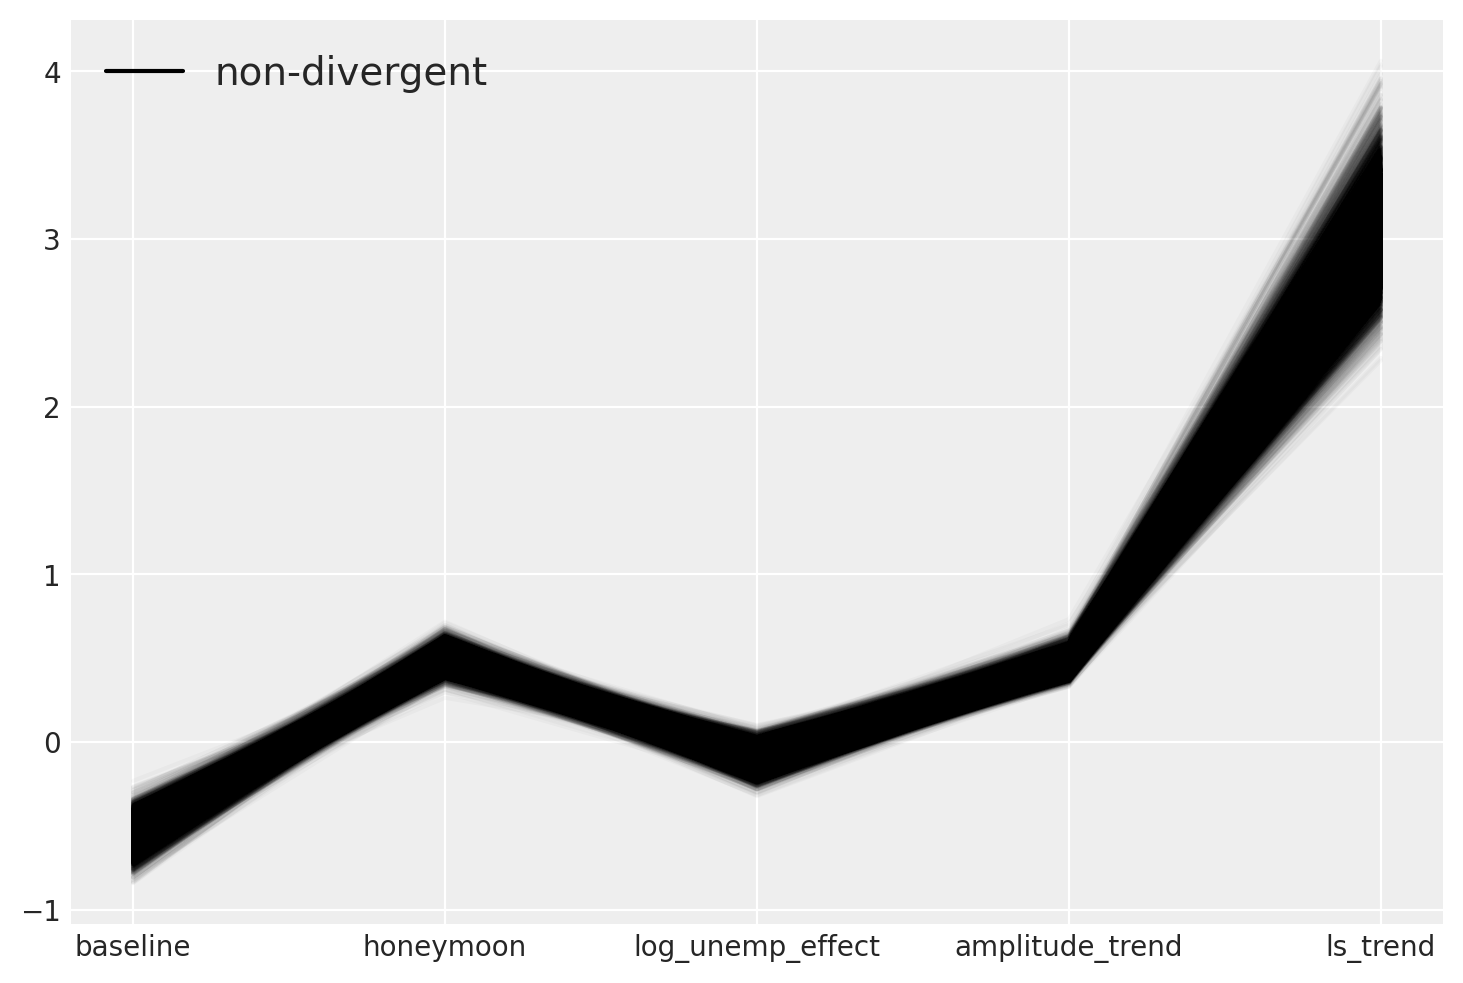

In [21]:
az.plot_parallel(trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"]);

In [92]:
trace_econ = az.from_netcdf("trace_raw_econ.nc")

In [13]:
TIME_BEFORE_ORIGIN = 0
MAX_TIME = MAX_OBSERVED + 24  # 2 years out-of-sample
RANGE_OOS = MAX_TIME + TIME_BEFORE_ORIGIN

tnew = np.linspace(-TIME_BEFORE_ORIGIN, MAX_TIME, RANGE_OOS)[:, None]

In [90]:
log_unemp = np.log(d.unemployment)

# unemployment stays around last value
ppc_unemp = np.random.normal(loc=d.unemployment.iloc[-1], scale=d.unemployment.std(), size=(MAX_TIME - MAX_OBSERVED) // 3)
# data only observed quarterly, so need to forward-fill
ppc_unemp = np.repeat(ppc_unemp, repeats=3)

# log to data and scale
stdz_log_ppc_unemp = (np.log(ppc_unemp) - log_unemp.mean()) / log_unemp.std()

# add noise around values
oos_unemp = stdz_log_ppc_unemp + np.random.normal(loc=trace_econ.posterior["u_diff"].mean(), scale=trace_econ.posterior["u_diff"].std(), size=MAX_TIME - MAX_OBSERVED)
oos_unemp

array([-3.43574926, -3.50795677, -3.31179495, -1.95382873, -1.93132262,
       -1.68343532, -2.12031026, -2.11240054, -2.04530069, -2.88724429,
       -2.92536984, -2.79188774, -1.77113374, -1.97645739, -1.86912101,
       -2.33392283, -2.44142453, -2.66594228, -1.44410714, -1.65043692,
       -1.5300695 , -1.2043214 , -1.14517556, -1.30226203])

In [144]:
# unemployment jumps to 10%
ppc_unemp_10 = np.random.normal(loc=10., scale=d.unemployment.std(), size=(MAX_TIME - MAX_OBSERVED) // 3)
# data only observed quarterly, so need to forward-fill
ppc_unemp_10 = np.repeat(ppc_unemp_10, repeats=3)

# log to data and scale
stdz_log_ppc_unemp_10 = (np.log(ppc_unemp_10) - log_unemp.mean()) / log_unemp.std()

# add noise around values
oos_unemp_10 = stdz_log_ppc_unemp_10 + np.random.normal(loc=trace_econ.posterior["u_diff"].mean(), scale=trace_econ.posterior["u_diff"].std(), size=MAX_TIME - MAX_OBSERVED)
oos_unemp_10

array([ 2.00028927,  1.85542338,  2.05651965,  0.86380401,  0.99534884,
        0.99426633,  1.91654478,  1.96004051,  1.7192617 ,  0.02767477,
       -0.07963859, -0.04750338,  1.79867063,  1.836759  ,  1.84867079,
        1.76705489,  1.66210574,  1.78087556,  1.10378158,  1.13340993,
        0.99999854,  1.00376217,  1.13615966,  0.87194602])

In [189]:
# unemployment drops to 5%
ppc_unemp_5 = np.random.normal(loc=5., scale=d.unemployment.std(), size=(MAX_TIME - MAX_OBSERVED) // 3)
# data only observed quarterly, so need to forward-fill
ppc_unemp_5 = np.repeat(ppc_unemp_5, repeats=3)

# log to data and scale
stdz_log_ppc_unemp_5 = (np.log(ppc_unemp_5) - log_unemp.mean()) / log_unemp.std()

# add noise around values
oos_unemp_5 = stdz_log_ppc_unemp_5 + np.random.normal(loc=trace_econ.posterior["u_diff"].mean(), scale=trace_econ.posterior["u_diff"].std(), size=MAX_TIME - MAX_OBSERVED)
oos_unemp_5

array([-6.77671578, -6.92508406, -6.86364175, -5.14370515, -5.12038605,
       -4.97899088, -7.02047438, -6.89965662, -7.13819949, -6.2738765 ,
       -6.00452285, -6.24274681, -2.77728581, -2.74108978, -2.88515404,
       -3.84990137, -4.03759832, -3.74154611, -6.89108645, -6.90923505,
       -7.04833197, -5.04782692, -5.09145264, -5.05764372])

In [94]:
with econ_latent_gp:
    pm.set_data(
        {
            "election_flag": np.concatenate(
                (
                    d.election_flag.values,
                    np.zeros(
                        MAX_TIME - MAX_OBSERVED, dtype=int
                    ),
                )
            ),
            "stdz_log_unemployment": np.concatenate(
                (
                    standardize(log_unemp).values,
                    oos_unemp
                )
            ),
        }
    )
    f_time_new = gp.conditional("f_time_new3", Xnew=tnew)

    ppc = pm.sample_posterior_predictive(
        trace_econ.posterior, samples=1000, var_names=["baseline", "f_time_new3", "honeymoon", "log_unemp_effect"]
    )

    az.from_pymc3_predictions(
        ppc,
        idata_orig=trace_econ,
        inplace=True,
        coords={"timesteps": np.arange(RANGE_OOS)},
        dims={"f_time_new3": ["timesteps"]},
    )

trace_econ

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

In [148]:
pp_prop = (
    logistic(
        trace_econ.predictions["baseline"]
        + trace_econ.predictions["f_time_new3"]
        + trace_econ.predictions["honeymoon"]
        * trace_econ.predictions_constant_data["election_flag"]
        + trace_econ.predictions["log_unemp_effect"]
        * trace_econ.predictions_constant_data["stdz_log_unemployment"]
    )
)

ValueError: operands could not be broadcast together with shapes (1,1000) (244,) 

In [168]:
pp_prop_10 = (
    logistic(
        trace_econ.predictions["baseline"]
        + trace_econ.predictions["f_time_new3"]
        + trace_econ.predictions["honeymoon"]
        * trace_econ.predictions_constant_data["election_flag"]
        + trace_econ.predictions["log_unemp_effect"]
        * xr.DataArray(np.concatenate((standardize(log_unemp).values, oos_unemp_10)), dims=["timesteps"], coords={"timesteps": np.arange(RANGE_OOS)})
    )
)

In [181]:
pp_prop_10.sel(timesteps=slice(MAX_OBSERVED, MAX_TIME))

<xarray.DataArray (chain: 1, draw: 1000, timesteps: 24)>
array([[[0.38882995, 0.38957782, 0.38806416, ..., 0.38563187,
         0.3822222 , 0.4015164 ],
        [0.28273207, 0.28730745, 0.32410083, ..., 0.28158212,
         0.28212367, 0.33134847],
        [0.27823691, 0.26656932, 0.27243124, ..., 0.30445425,
         0.28021703, 0.27607644],
        ...,
        [0.20992816, 0.18908255, 0.1905109 , ..., 0.39383105,
         0.35797597, 0.39624601],
        [0.41459507, 0.44471498, 0.41180439, ..., 0.70590331,
         0.68293329, 0.58814123],
        [0.32573785, 0.3786408 , 0.39543514, ..., 0.19909202,
         0.20605928, 0.26835413]]])
Coordinates:
  * chain      (chain) int64 0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * timesteps  (timesteps) int64 220 221 222 223 224 225 ... 239 240 241 242 243

In [180]:
pp_dates[MAX_OBSERVED:]

array(['2020-09-30T00:00:00.000000000', '2020-10-31T00:00:00.000000000',
       '2020-11-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000',
       '2021-01-31T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
       '2021-03-31T00:00:00.000000000', '2021-04-30T00:00:00.000000000',
       '2021-05-31T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
       '2021-07-31T00:00:00.000000000', '2021-08-31T00:00:00.000000000',
       '2021-09-30T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
       '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
       '2022-01-31T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
       '2022-03-31T00:00:00.000000000', '2022-04-30T00:00:00.000000000',
       '2022-05-31T00:00:00.000000000', '2022-06-30T00:00:00.000000000',
       '2022-07-31T00:00:00.000000000', '2022-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [190]:
pp_prop_5 = (
    logistic(
        trace_econ.predictions["baseline"]
        + trace_econ.predictions["f_time_new3"]
        + trace_econ.predictions["honeymoon"]
        * trace_econ.predictions_constant_data["election_flag"]
        + trace_econ.predictions["log_unemp_effect"]
        * xr.DataArray(np.concatenate((standardize(log_unemp).values, oos_unemp_5)), dims=["timesteps"], coords={"timesteps": np.arange(RANGE_OOS)})
    )
)

In [ ]:
pm.gp.util.plot_gp_dist(ax, pp_prop.data.T, pp_dates, plot_samples=True, palette="Blues")

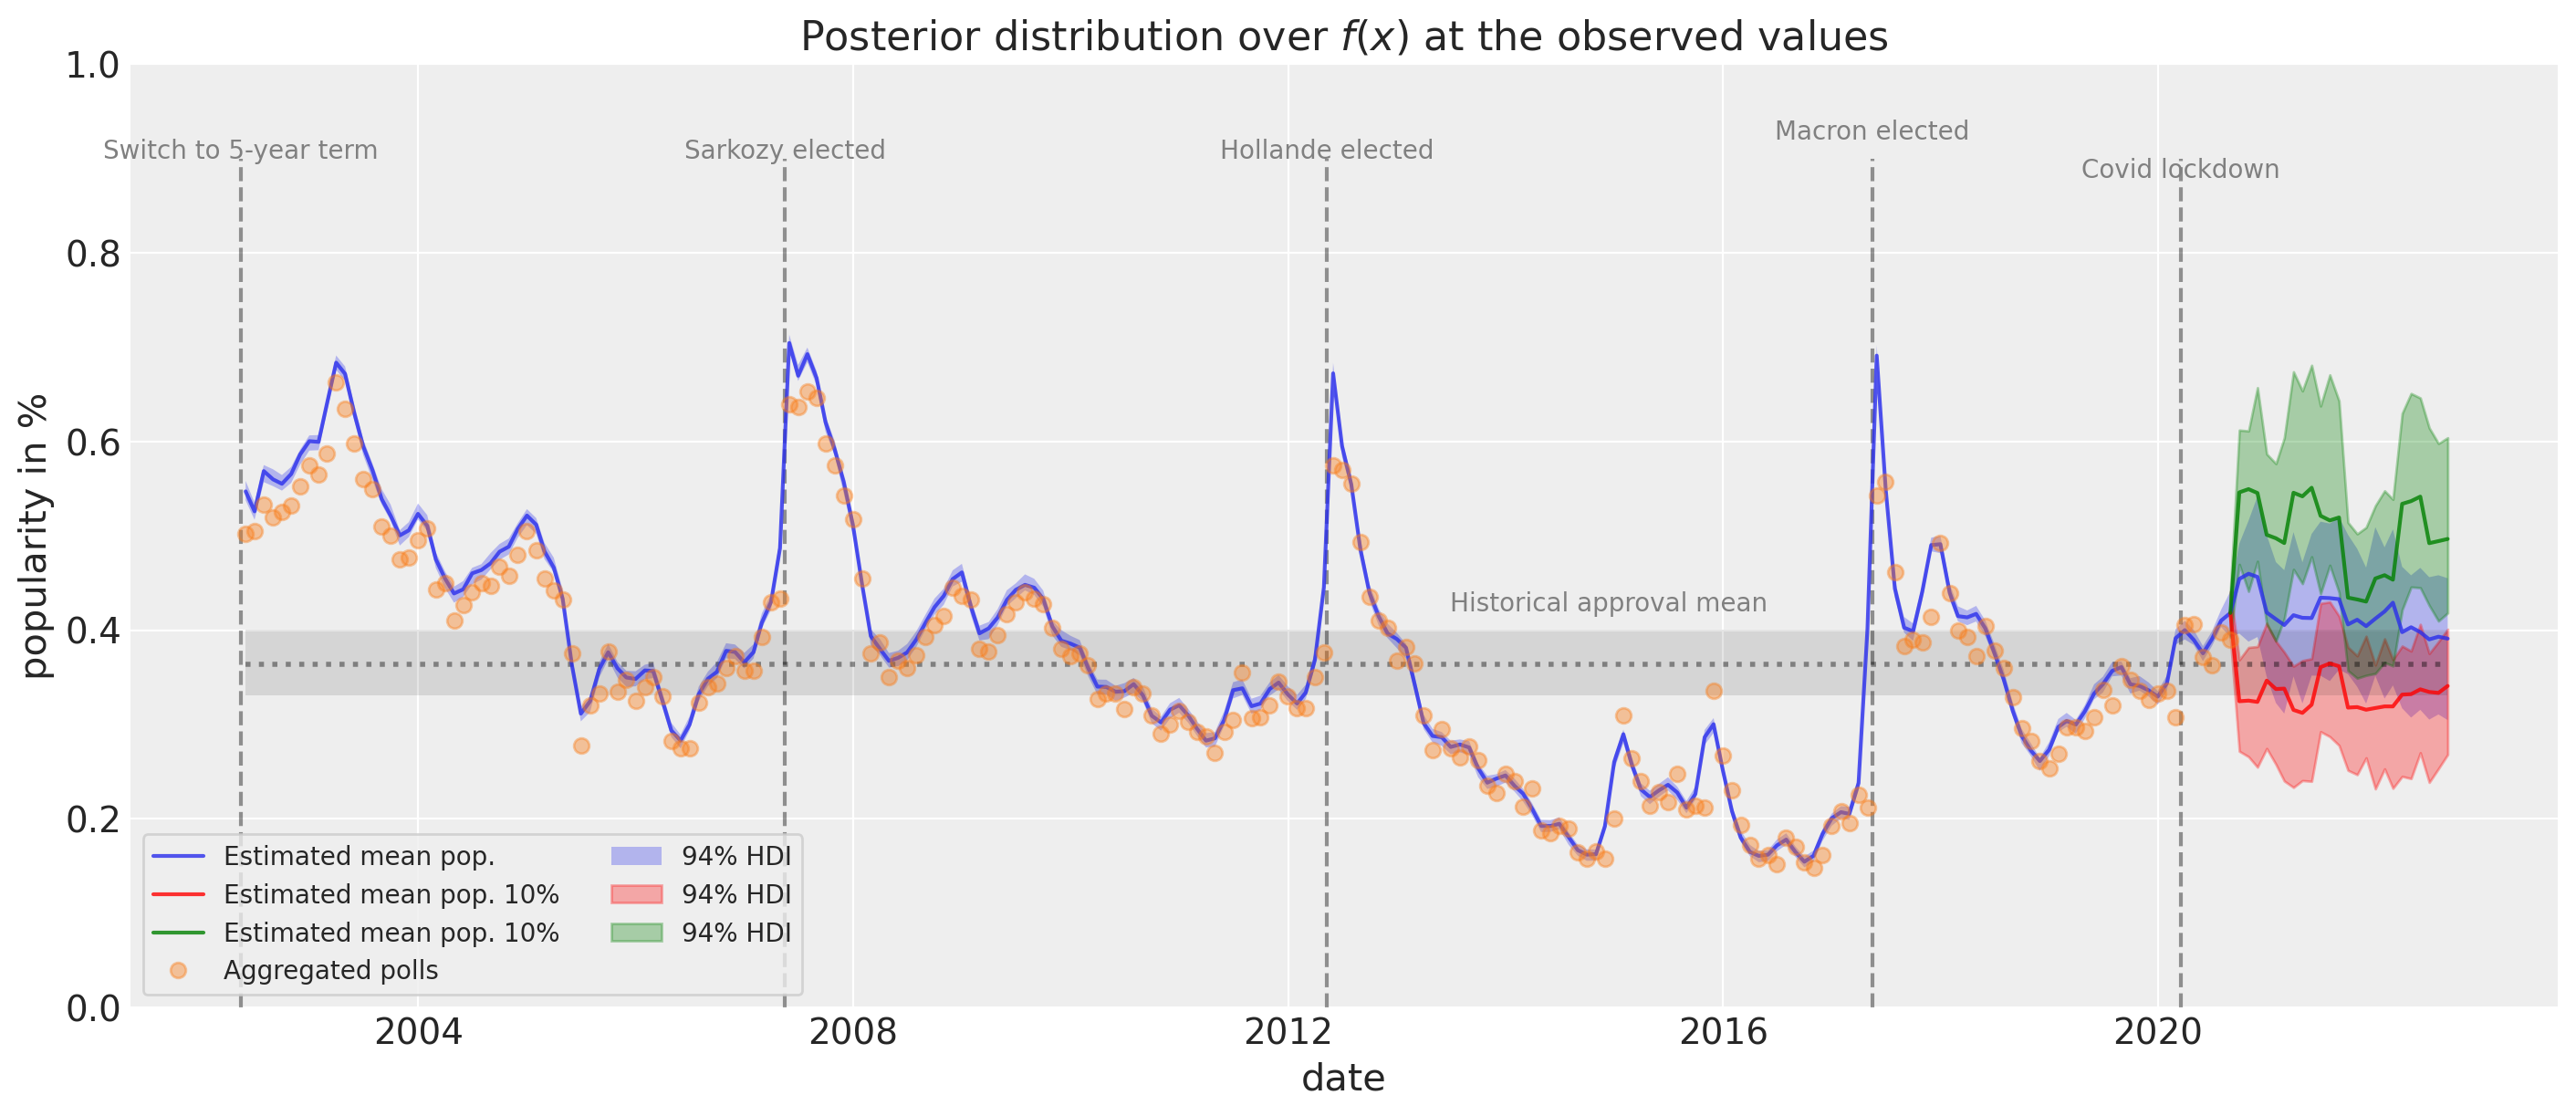

In [193]:
# plot the results
_, ax = plt.subplots(1, 1, figsize=(14, 6))

pp_dates = pd.date_range(
    start=d.index[0] - np.timedelta64(TIME_BEFORE_ORIGIN, "M"),
    periods=RANGE_OOS,
    freq="M",
).values

# plot the samples from the gp posterior with samples and shading
ax.plot(pp_dates, pp_prop.median(("chain", "draw")), alpha=0.8, label="Estimated median pop.")
pm.gp.util.plot_gp_dist(ax, pp_prop.data.T, pp_dates, plot_samples=True, palette="Blues")
ax.fill_between(
    pp_dates,
    az.hdi(pp_prop, hdi_prob=0.5).sel(hdi="lower")["x"],
    az.hdi(pp_prop, hdi_prob=0.5).sel(hdi="higher")["x"],
    alpha=0.3,
    label="94% HDI"
)

ax.plot(pp_dates[MAX_OBSERVED - 1:], pp_prop_10.sel(timesteps=slice(MAX_OBSERVED - 1, MAX_TIME)).median(("chain", "draw")), alpha=0.8, label="Estimated mean pop. 10%", color="r")
ax.fill_between(
    pp_dates[MAX_OBSERVED - 1:],
    az.hdi(pp_prop_10.sel(timesteps=slice(MAX_OBSERVED - 1, MAX_TIME)), hdi_prob=0.5).sel(hdi="lower")["x"],
    az.hdi(pp_prop_10.sel(timesteps=slice(MAX_OBSERVED - 1, MAX_TIME)), hdi_prob=0.5).sel(hdi="higher")["x"],
    alpha=0.3,
    label="94% HDI",
    color="r"
)

ax.plot(pp_dates[MAX_OBSERVED - 1:], pp_prop_5.sel(timesteps=slice(MAX_OBSERVED - 1, MAX_TIME)).median(("chain", "draw")), alpha=0.8, label="Estimated mean pop. 10%", color="g")
ax.fill_between(
    pp_dates[MAX_OBSERVED - 1:],
    az.hdi(pp_prop_5.sel(timesteps=slice(MAX_OBSERVED - 1, MAX_TIME)), hdi_prob=0.5).sel(hdi="lower")["x"],
    az.hdi(pp_prop_5.sel(timesteps=slice(MAX_OBSERVED - 1, MAX_TIME)), hdi_prob=0.5).sel(hdi="higher")["x"],
    alpha=0.3,
    label="94% HDI",
    color="g"
)

# plot the data
ax.plot(d.index, d.p_approve.values, "o", color="C1", alpha=0.4, label="Aggregated polls")

ax.hlines(
    logistic(trace_econ.predictions["baseline"].mean()),
    pp_dates[0],
    pp_dates[-1],
    "k",
    ":",
    alpha=0.4,
    lw=2,
)
ax.fill_between(
    pp_dates,
    logistic(az.hdi(trace_econ.predictions)["baseline"]).sel(hdi="lower"),
    logistic(az.hdi(trace_econ.predictions)["baseline"]).sel(hdi="higher"),
    color="k",
    edgecolor="none",
    alpha=0.1,
)
ax.text(
    pd.to_datetime("2014-12-14"),
    0.42,
    "Historical approval mean",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2002-05-14"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2002-05-14"),
    0.9,
    "Switch to 5-year term",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2007-05-16"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2007-05-16"),
    0.9,
    "Sarkozy elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2012-05-11"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2012-05-11"),
    0.9,
    "Hollande elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2017-05-17"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2017-05-17"),
    0.92,
    "Macron elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2020-03-17"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2020-03-17"),
    0.88,
    "Covid lockdown",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

# axis labels and title
ax.set_ylim((0, 1))
ax.set_xlabel("date")
ax.set_ylabel("popularity in %")
ax.set_title("Posterior distribution over $f(x)$ at the observed values")
plt.legend(fontsize=10, ncol=2, loc="lower left", frameon=True);

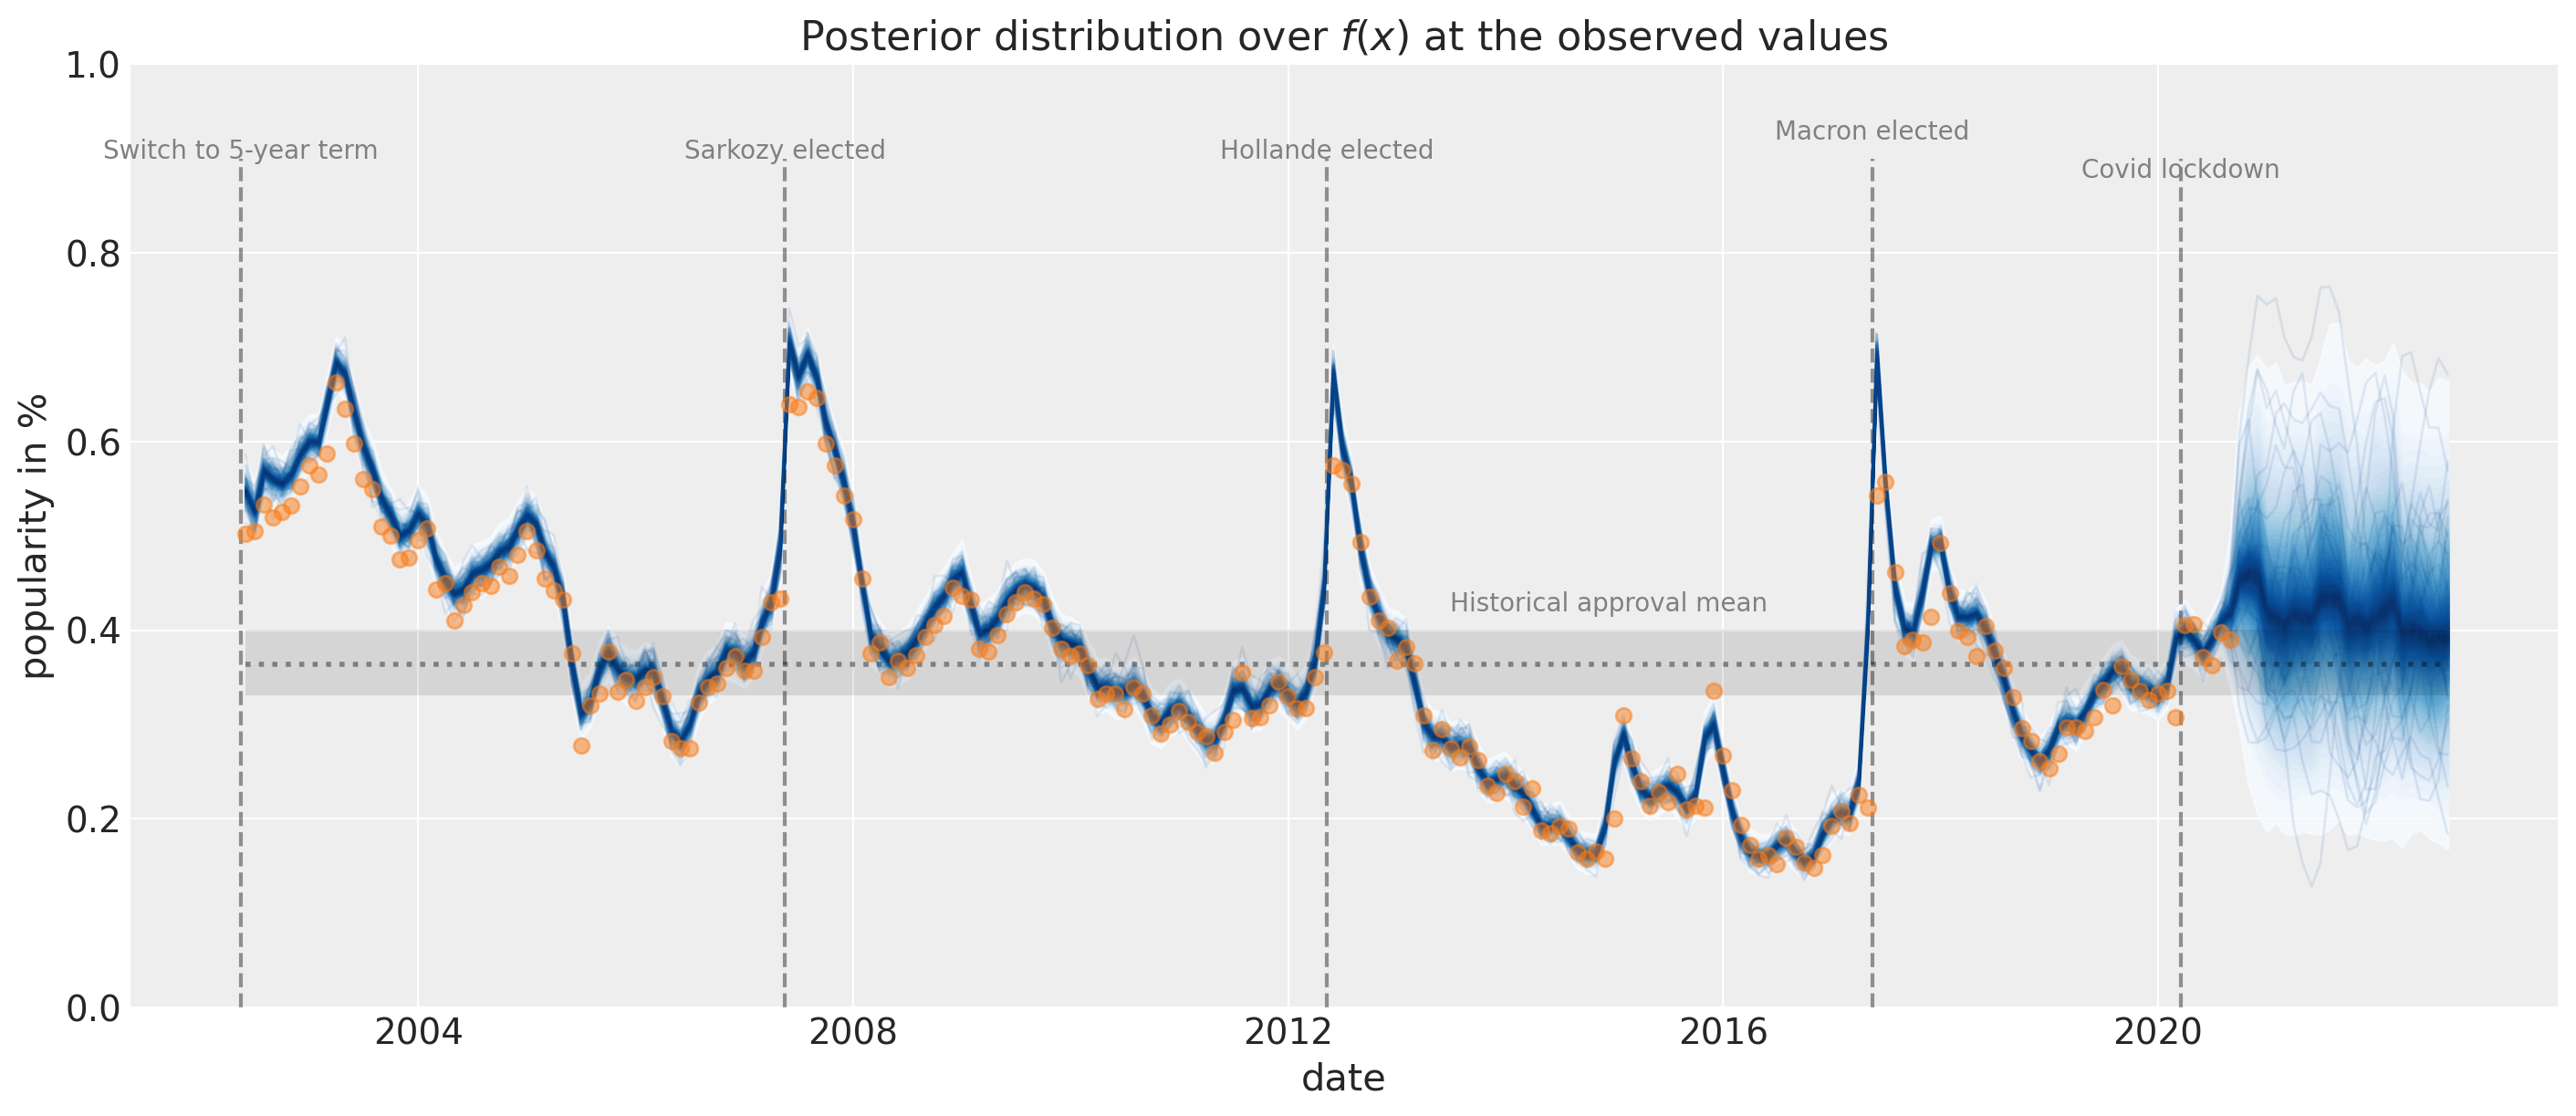

In [96]:
# plot the results
_, ax = plt.subplots(1, 1, figsize=(14, 6))

# plot the samples from the gp posterior with samples and shading
pp_prop = (
    logistic(
        trace_econ.predictions["baseline"]
        + trace_econ.predictions["f_time_new3"]
        + trace_econ.predictions["honeymoon"]
        * trace_econ.predictions_constant_data["election_flag"]
        + trace_econ.predictions["log_unemp_effect"]
        * trace_econ.predictions_constant_data["stdz_log_unemployment"]
    )
    .stack(sample=("chain", "draw"))
)
pp_dates = pd.date_range(
    start=d.index[0] - np.timedelta64(TIME_BEFORE_ORIGIN, "M"),
    periods=RANGE_OOS,
    freq="M",
).values
pm.gp.util.plot_gp_dist(ax, pp_prop.data.T, pp_dates, plot_samples=True, palette="Blues")

# plot the data
ax.plot(d.index, d.p_approve.values, "o", color="C1", alpha=0.5)

ax.hlines(
    logistic(trace_econ.predictions["baseline"].mean()),
    pp_dates[0],
    pp_dates[-1],
    "k",
    ":",
    alpha=0.4,
    lw=2,
)
ax.fill_between(
    pp_dates,
    logistic(az.hdi(trace_econ.predictions)["baseline"]).sel(hdi="lower"),
    logistic(az.hdi(trace_econ.predictions)["baseline"]).sel(hdi="higher"),
    color="k",
    edgecolor="none",
    alpha=0.1,
)
ax.text(
    pd.to_datetime("2014-12-14"),
    0.42,
    "Historical approval mean",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2002-05-14"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2002-05-14"),
    0.9,
    "Switch to 5-year term",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2007-05-16"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2007-05-16"),
    0.9,
    "Sarkozy elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2012-05-11"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2012-05-11"),
    0.9,
    "Hollande elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2017-05-17"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2017-05-17"),
    0.92,
    "Macron elected",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

ax.vlines(pd.to_datetime("2020-03-17"), 0.0, 0.9, "k", "--", alpha=0.4)
ax.text(
    pd.to_datetime("2020-03-17"),
    0.88,
    "Covid lockdown",
    fontsize=10,
    color="grey",
    horizontalalignment="center",
)

# axis labels and title
ax.set_ylim((0, 1))
ax.set_xlabel("date")
ax.set_ylabel("popularity in %")
ax.set_title("Posterior distribution over $f(x)$ at the observed values");